In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

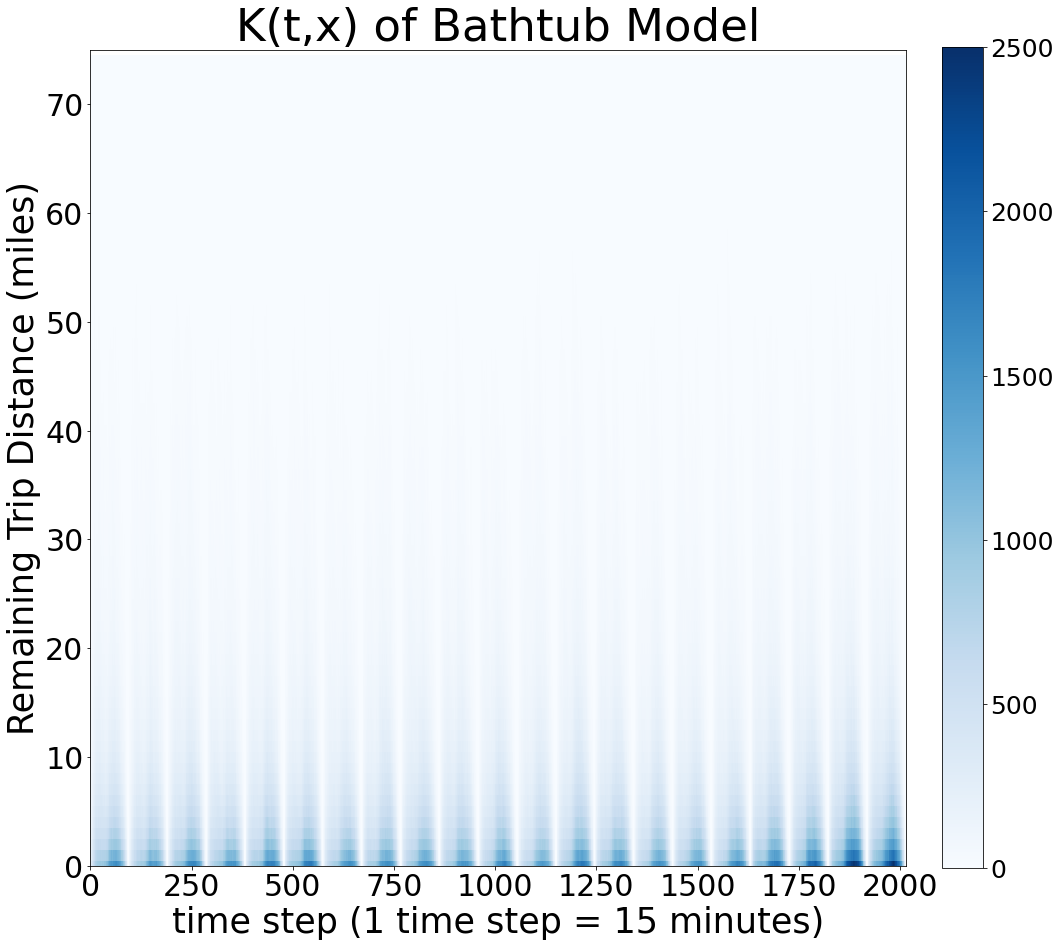

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.        , 0.02630273],
       [0.54054054, 0.8382134 ],
       [0.94594595, 0.23722084],
       ...,
       [0.47297297, 0.98957816],
       [0.06756757, 0.87394541],
       [0.54054054, 0.92704715]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,10,10,10,10,10,10,10,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.035081732325121441 0.068299033657805333 0.001864430992437554 1.9748067216204113
0.022723924252250744 0.043251630035715687 0.0021962184687858016 1.5800087860835899
0.020447554341500262 0.038049669802833308 0.0028454388801672148 1.4830536208049017
0.015335929674039121 0.026910652013722489 0.0037612073343557539 1.2493060788098853
0.00831817032563428 0.015340098524261382 0.001296242127007178 0.9475798892006393
0.0064008334669257722 0.011184001795572178 0.0016176651382793666 0.8142302436075437
0.0053661289882280866 0.0098898063766777872 0.00084245159977838519 0.7663456935246115
0.0050451725277565846 0.009130348394380032 0.0009599966611331367 0.7353930509927006
0.0049356732578632141 0.0087886373499910728 0.0010827091657353556 0.7206434705127946
0.0047553198657463479 0.0085558219206450081 0.00095481781084768766 0.7106362687106822
0.0041036110925666731 0.0077587039036680931 0.00044851828146525287 0.6766696340406829
0.00400386235857382 0.0076825270532810078 0.00032519766386663245 0.6743923899

0.0031722560558618846 0.0054339999032722878 0.000910512208451481 0.569712345784689
0.0031721675497055242 0.0054372600212317995 0.00090707507817924847 0.5698651651264641
0.0031720346528716281 0.0054367522913214067 0.00090731701442184939 0.5698227710116295
0.0031718710252422824 0.0054389257206525089 0.00090481632983205557 0.5699312330325665
0.0031717047340796972 0.0054428654710219565 0.00090054399713743747 0.5700738617017665
0.0031713928710642796 0.0054418034888404519 0.00090098225328810722 0.5700360738533682
0.0031711465238379996 0.0054376973664955553 0.00090459568118044387 0.5698362260598174
0.0031709417165182129 0.005436305065317542 0.00090557836771888375 0.5697570810133016
0.0031708568832022705 0.0054353758408631 0.00090633792554144167 0.5696984177273078
0.00317081086892082 0.00543623014005422 0.00090539159778741957 0.569743702461878
0.0031707609251980526 0.0054369438521284881 0.000904577998267617 0.5697965534532651
0.0031707377409967196 0.0054370353064092 0.00090444017558423883 0.56

0.0031460411958116842 0.0054217183196560723 0.00087036407196729615 0.5687430512684832
0.0031454012950568157 0.0054244318165783722 0.00086637077353525884 0.5688340482421523
0.003144866806558518 0.0053886941724614282 0.00090103944065560734 0.5668769554661921
0.0031440266172766927 0.0053999255672986029 0.00088812766725478241 0.5675643546753396
0.0031433297778261644 0.0054042110902690265 0.000882448465383302 0.5677609769156231
0.003142722234591968 0.00541247406251778 0.000872970406666156 0.5681699942586868
0.0031422684409084293 0.0054026596427313792 0.00088187723908547948 0.5676426916765854
0.0031417393779613837 0.0053979736171436161 0.00088550513877915155 0.5674022969838806
0.003141449059010269 0.0053811014515428995 0.00090179666647763888 0.5666355794795997
0.0031410487200834078 0.0053887099830350615 0.00089338745713175437 0.5670197621926433
0.0031409821194370445 0.0053871208899762225 0.00089484334889786674 0.5669521059943684
0.0031409132975879885 0.005386199512403286 0.000895627082772690

0.0030749244040833381 0.0052932044117952144 0.000856644396371462 0.5616334228838462
0.00307482715788942 0.00528979617630565 0.00085985813947319 0.5614889917074
0.0030746180362066344 0.0052954161524993992 0.00085381991991386992 0.56176751374971
0.0030744183039573192 0.0052948276402645274 0.0008540089676501105 0.5617258407568638
0.0030742539302169194 0.0052947630079453849 0.00085374485248845367 0.5617342449949742
0.0030739147296035725 0.0052920967265706756 0.0008557327326364695 0.5616051899361314
0.0030736969434582021 0.0052934594578615763 0.00085393442905482779 0.5616882370478099
0.0030734686295877 0.00529164373921488 0.00085529351996052019 0.5616004718311927
0.0030732414433337755 0.0052890898429580231 0.000857393043709528 0.5614442147676872
0.0030731333087349339 0.005289623285286228 0.00085664333218363935 0.5614807596877578
0.0030730390285066667 0.0052917402773698915 0.00085433777964344219 0.561550481232291
0.0030729629240869405 0.005293411641696273 0.00085251420647760776 0.56165873396

0.0030575367439825184 0.0052641301604153855 0.00085094332754965087 0.5602500453180477
0.00305743293996974 0.0052657379926764484 0.00084912788726303169 0.5603303564374048
0.0030573038540379904 0.0052661069262907008 0.00084850078178528047 0.5603457416105502
0.0030572191823624723 0.00525805612181952 0.00085638224290542466 0.5599256926669157
0.0030571511147210887 0.0052646647966748464 0.00084963743276733064 0.560299721284331
0.0030570543014294335 0.00526836162869173 0.00084574697416713734 0.5605015952249146
0.0030569669427642047 0.00526321131117852 0.00085072257434988974 0.5602017167302394
0.0030568817685618405 0.0052595129950005213 0.00085425054212315938 0.5600103300879405
0.0030567576500260462 0.0052582085912812656 0.00085530670877082655 0.559929210757838
0.003056644807558186 0.0052562877082946756 0.000857001906821696 0.55982127431009
0.0030564717157236794 0.0052599010467144613 0.00085304238473289738 0.5599981214073986
0.0030562460596938439 0.0052653727374637081 0.00084711938192397987 0.

0.0030437097602987761 0.0052404963083396419 0.00084692321225791022 0.5589556428060657
0.0030436350060959296 0.00524168342443508 0.00084558658775677831 0.5590282454536262
0.0030435497893701053 0.00524058240438092 0.00084651717435929087 0.5589637446037282
0.0030434575319693443 0.0052404345258609056 0.00084648053807778289 0.5589424548326378
0.0030434179781519961 0.0052428923434553777 0.00084394361284861462 0.5590782347031336
0.0030433946199423982 0.0052408139099025548 0.00084597532998224206 0.5589742430925674
0.0030433823323930713 0.0052416147304919216 0.00084514993429422132 0.5590187989805995
0.0030433768660716965 0.0052414444007977869 0.00084530933134560572 0.5590118875118198
0.0030433683114516078 0.0052413210706836509 0.00084541555221956453 0.5590042211238901
0.0030433349622499047 0.00524116201976708 0.00084550790473272971 0.5590002450744234
0.0030432636261754271 0.0052403125217738208 0.00084621473057703363 0.5589522997167384
0.0030431171373198141 0.00524130705214377 0.0008449272224958

0.0030387489897877127 0.0052411958006177463 0.00083630217895767933 0.5589645961277796
0.0030387420568709772 0.00524054303413414 0.000836941079607814 0.5589343020510821
0.0030387257648143112 0.0052394822109064409 0.00083796931872218172 0.5588778973151511
0.0030386931060529497 0.0052391258737594067 0.0008382603383464926 0.5588673807928308
0.0030386650312109304 0.0052384953911503692 0.0008388346712714913 0.5588421009150004
0.00303860180338421 0.0052394921379883335 0.00083771146878008668 0.5588881640849114
0.0030385437465244121 0.0052403658109533048 0.00083672168209551886 0.5589316677391771
0.0030384908637390287 0.0052442888052425373 0.00083269292223551962 0.5591180655898618
0.0030383882048111593 0.005243593175329163 0.00083318323429315555 0.5591110983333192
0.0030383275377450268 0.0052413523017375563 0.000835302773752497 0.5589771544604971
0.0030382114875130957 0.0052417221806992887 0.00083470079432690282 0.5590230466732815
0.0030381800619337278 0.0052442405230357378 0.0008321196008317181

0.0030338396990049346 0.0052277176836390757 0.00083996171437079382 0.5584271695539136
0.00303380626714281 0.0052268594842581262 0.000840753050027494 0.5583891562261291
0.0030337644632944067 0.0052284674362427334 0.00083906149034607982 0.558478923605947
0.003033706137556734 0.005228422984003213 0.00083898929111025488 0.5584778518710987
0.003033622188723906 0.0052274348440128 0.00083980953343501183 0.5584381722477135
0.0030335501786375937 0.0052284004181801158 0.000838699939095072 0.5584931358764705
0.00303347864775223 0.00522840327341227 0.00083855402209218988 0.5585213531108472
0.0030333976147045353 0.0052311458655168357 0.00083564936389223508 0.5586589694648894
0.0030333287674180497 0.0052272444251158208 0.00083941310972027844 0.5584713965389398
0.0030333065264079328 0.0052290588857295851 0.00083755416708628069 0.5585703927617213
0.0030332830370678903 0.0052303491700817824 0.00083621690405399831 0.558633897980092
0.0030332580198535394 0.0052312424362847424 0.00083527360342233671 0.558

0.0030214242853937546 0.0052081690430917345 0.00083467952769577484 0.5574805331261519
0.0030214079543492965 0.0052078129795227667 0.00083500292917582607 0.5574559609700267
0.003021396201445219 0.0052074617330086087 0.000835330669881829 0.5574326979313005
0.0030213805119152955 0.0052073349536025859 0.00083542607022800517 0.5574257927736035
0.0030213227671897183 0.0052066958114357388 0.00083594972294369775 0.5573931206415215
0.0030212455321097123 0.0052063324808179134 0.00083615858340151117 0.5573800868243075
0.0030211283491260506 0.0052061780061414238 0.00083607869211067777 0.5573792906930565
0.0030210669240308351 0.0052061735566584551 0.000835960291403215 0.5573828034872689
0.0030210145313084129 0.00520634789956412 0.00083568116305270514 0.5573666798601181
0.0030209737894715061 0.0052060035187439608 0.00083594406019905183 0.5573569753732995
0.0030209085923367544 0.0052070833480648481 0.00083473383660866076 0.5574145555231917
0.0030208710984313833 0.0052063009710343229 0.000835441225828

0.0030080726387011459 0.0051740099116282705 0.000842135365774021 0.5557935266375811
0.0030080359234368513 0.0051750274721098768 0.00084104437476382543 0.5558365671719446
0.0030079763432090067 0.0051730538980075905 0.00084289878841042312 0.5557111025052102
0.0030079339488164564 0.0051736057537612188 0.00084226214387169416 0.555735871092324
0.0030078978360927873 0.0051715947223230736 0.00084420094986250129 0.5556318594369353
0.0030078593863279053 0.0051695044053420933 0.0008462143673137175 0.5555283856496065
0.0030078154583710092 0.005168543991542574 0.0008470869251994439 0.5554755308820246
0.00300774402836279 0.0051702234034261352 0.00084526465329944479 0.5555579279228433
0.0030076507214151088 0.0051716834028633979 0.00084361803996681976 0.5556257280325583
0.003007516451140382 0.0051739657655123584 0.00084106713676840533 0.5557453390408301
0.0030072923082261407 0.0051699688964915082 0.00084461571996077313 0.5555233217904405
0.0030071022803527855 0.0051740754992372195 0.00084012906146835

0.0029893563961237344 0.0050922058148924554 0.00088650697735501334 0.5513074369564284
0.0029890709839574463 0.0051060840117062526 0.00087205795620864013 0.5520705510174537
0.0029889806202002861 0.0051132212879207951 0.00086473995247977724 0.5524857975829356
0.0029887198860942023 0.0051059449759912568 0.00087149479619714749 0.5520799327078928
0.002988598261437863 0.0051016891643132717 0.00087550735856245455 0.5518501388716208
0.0029885320373800473 0.00510200567683539 0.0008750583979247041 0.5518721114888896
0.0029884432228958805 0.0051028295651883264 0.00087405688060343458 0.551913973385296
0.0029883308533667609 0.0051022803922975181 0.00087438131443600407 0.5518950518979109
0.0029882099286913343 0.0051020272603965753 0.00087439259698609347 0.5518876634282867
0.0029879964085010808 0.0051023954069616545 0.00087359741004050691 0.5519152908147379
0.0029877380035147677 0.0050998664694537873 0.00087560953757574776 0.5517865844983296
0.0029874596685607194 0.0050952495756064944 0.0008796697615

0.0029710370826418007 0.0050660028566484354 0.00087607130863516589 0.5500850188347922
0.0029709540348051254 0.0050696470925870336 0.00087226097702321681 0.5502671808337739
0.0029708648195735403 0.0050678913771806432 0.00087383826196643752 0.5501662582545679
0.0029707787213993069 0.0050670883289919665 0.00087446911380664705 0.5501469569855424
0.0029706822303997358 0.0050649618498804809 0.000876402610918991 0.5500286886626226
0.0029705986361652269 0.0050640931018947491 0.0008771041704357048 0.5499898785368327
0.0029704403809355695 0.0050598968218462754 0.00088098394002486329 0.5497774054882083
0.0029702504860454619 0.0050590166810222841 0.00088148429106863944 0.5497621437497713
0.0029700401339945769 0.0050598872409354841 0.00088019302705366924 0.5498086332245846
0.0029698927806255356 0.0050605014150191625 0.00087928414623190823 0.5498093092774083
0.0029698600932162224 0.0050632928533490143 0.00087642733308343046 0.5499819491641353
0.0029697254387704157 0.00506085629706723 0.0008785945804

0.0029625358620462136 0.0050619507897776608 0.00086312093431476639 0.5497852838515082
0.0029624627269952881 0.0050591080642979095 0.00086581738969266654 0.5496382705876445
0.002962359182024637 0.0050607294692876625 0.00086398889476161159 0.5497335278525893
0.0029622009269745352 0.00506399940575984 0.00086040244818923 0.5498983100201478
0.0029620216943442535 0.0050682357525374229 0.00085580763615108427 0.5501310343965891
0.0029617650410475771 0.0050646535735804606 0.00085887650851469385 0.549937200980355
0.0029613915062358326 0.0050621348157326128 0.00086064819673905245 0.5497982408464613
0.0029610105478309542 0.0050717971810926542 0.00085022391456925463 0.5503188895520046
0.0029607234668601315 0.005066023907778449 0.00085542302594181436 0.5499792526107635
0.002960556143331571 0.00506320676851539 0.00085790551814775241 0.5498208186339574
0.0029604087458322435 0.00506603973188858 0.00085477775977590769 0.549983732540196
0.0029602881434441942 0.0050610235528935326 0.00085955273399485554 0

0.0029511460468779277 0.0050453368803714546 0.000856955213384401 0.549009734511217
0.0029511235986476344 0.0050455247710489435 0.00085672242624632564 0.5490161882923419
0.0029511034998832581 0.0050468036155345347 0.000855403384231982 0.5490772256849571
0.0029510742941070167 0.0050473330567481012 0.00085481553146593244 0.5490974945778663
0.0029510246727206695 0.0050470578710250279 0.0008549914744163114 0.5490796759973475
0.0029509664326930305 0.0050462783582576661 0.0008556545071283949 0.5490383721207881
0.0029509005601437589 0.0050450571049486716 0.000856744015338846 0.548978864645936
0.0029508436446890013 0.0050439581551326353 0.00085772913424536688 0.5489216721123124
0.0029508041059488318 0.0050441859229481793 0.00085742228894948407 0.5489463875390092
0.0029507589170128814 0.0050447079730537433 0.0008568098609720192 0.548975516888116
0.0029506910588978697 0.005046284220305456 0.00085509789749028324 0.5490614883030889
0.0029506026211146225 0.0050473105073581938 0.0008538947348710515 0

0.0029433630981316513 0.0050434467751620908 0.00084327942110121168 0.5489652512406005
0.0029433501043257143 0.00504347859047968 0.000843221618171749 0.5489715466376992
0.0029433339927377338 0.005043214328497022 0.00084345365697844547 0.5489621031979175
0.00294330449009769 0.005043252912258967 0.00084335606793641351 0.5489658988015096
0.0029432444816488651 0.005042682846588444 0.00084380611670928666 0.548937195857846
0.0029431553772685682 0.00504206088184236 0.00084424987269477684 0.5489097277983075
0.0029431347591978027 0.0050418783420146922 0.00084439117638091335 0.5488886423142746
0.0029430651984479568 0.005042252807235084 0.00084387758966083 0.5489080555544636
0.0029430099069664151 0.0050427681797075219 0.0008432516342253085 0.5489416471474942
0.0029429974480179306 0.0050442557580051336 0.000841739138030728 0.5490078306357549
0.0029429650636409758 0.0050438495530425106 0.000842080574239441 0.5489957333722514
0.0029429472619870484 0.0050437053867822372 0.00084218913719185957 0.548990

0.0029399626782036026 0.0050349304424290673 0.00084499491397813813 0.5484287803137148
0.0029399365320167295 0.005034278007078302 0.000845595056955157 0.548392491416283
0.0029399302453673106 0.0050331010617312754 0.00084675942900334553 0.5483168534241087
0.0029399193546913952 0.0050335247628098554 0.00084631394657293463 0.5483423521617471
0.0029399143423807957 0.0050336649894112424 0.000846163695350349 0.5483509133995891
0.0029399052918165913 0.0050335766154230663 0.00084623396821011652 0.5483439719535298
0.0029398940981110282 0.005034992714568292 0.000844795481653764 0.5484112078856795
0.0029398837859755207 0.0050340731395341091 0.00084569443241693236 0.5483584609839809
0.0029398719217148379 0.0050343690735440826 0.00084537476988559308 0.5483733883587112
0.0029398544641794835 0.005034905408013623 0.00084480352034534373 0.5484037725954797
0.0029398333907760948 0.0050347629179761559 0.00084490386357603364 0.5484001099807047
0.0029398057140814526 0.0050346883679224606 0.000844923060240444

0.0029349813053492521 0.0050299694122947812 0.00083999319840372306 0.5481746790951533
0.002934940499708767 0.0050296296396032756 0.00084025135981425844 0.5481632336187049
0.0029349098309128896 0.0050283148088713656 0.00084150485295441388 0.5480969961034293
0.0029348870154564323 0.0050291366104827512 0.00084063742043011366 0.5481525928546989
0.002934847532606112 0.0050277661119268206 0.00084192895328540345 0.5480818927602259
0.0029348235990862017 0.0050267227309724128 0.0008429244671999906 0.5480213830984497
0.0029347985020428844 0.0050267725570038177 0.00084282444708195137 0.5480267140166883
0.0029347697598998191 0.0050269178228240091 0.00084262169697562879 0.5480400590404706
0.0029347455437639426 0.0050268693532809642 0.00084262173424692118 0.5480340072356809
0.0029347168956851306 0.0050275061378411787 0.00084192765352908243 0.5480730416029301
0.0029346741493873544 0.0050282988983902342 0.00084104940038447445 0.5481039405528636
0.0029346311960335714 0.0050285998118169382 0.00084066258

0.0029292152883426876 0.0050147490812500152 0.00084368149543535972 0.5473610558976287
0.0029291268973144317 0.0050153022236230265 0.00084295157100583689 0.547375613477272
0.002929067107227467 0.0050191298392041825 0.00083900437525075112 0.5475848705375439
0.0029290076887318584 0.0050180327781219119 0.00083998259934180467 0.5475213101439982
0.0029289323236352531 0.0050174177675903608 0.00084044687968014569 0.5474897299497417
0.0029288580100233917 0.0050176044609941866 0.00084011155905259723 0.5475008405643808
0.002928831384837508 0.0050198692165475721 0.00083779355312744357 0.5476168748029728
0.0029287739195175411 0.0050181441245863634 0.00083940371444871889 0.5475220862079981
0.0029287467802027512 0.0050169824532562577 0.0008405111071492444 0.5474615965342369
0.0029287059619279984 0.0050169475566568585 0.00084046436719913858 0.5474502288695471
0.002928645308835639 0.0050172068704129741 0.00084008374725830443 0.5474528853988551
0.00292857915877767 0.0050178608676673432 0.000839297449887

0.0029253694110347446 0.0050169346088192639 0.00083380421325022548 0.5475473170750673
0.0029253588358769921 0.0050168850363494413 0.00083383263540454274 0.5475405475900859
0.0029253479013332888 0.0050164988292109771 0.0008341969734556009 0.5475189908326605
0.0029253349463083137 0.00501650457403103 0.00083416531858559767 0.5475187972995458
0.0029253178231756494 0.0050158397961925227 0.00083479585015877643 0.5474838597946322
0.0029253032755822903 0.0050157112745233285 0.00083489527664125233 0.5474827775487232
0.0029252717180394939 0.0050151522711947621 0.00083539116488422574 0.5474522293747232
0.0029252247122274291 0.0050152539227169635 0.00083519550173789489 0.5474590463224219
0.0029251789964538314 0.0050148797870017787 0.00083547820590588442 0.5474365533783525
0.0029251507185154473 0.005015192348830546 0.000835109088200349 0.5474575202261209
0.0029251210501177365 0.005016804202711553 0.00083343789752392012 0.5475379621489886
0.0029250950662343049 0.0050159329083721959 0.000834257224096

0.0029221169275282744 0.0050059730340740651 0.00083826082098248378 0.5469055256323787
0.0029221095023840042 0.0050064943371727049 0.000837724667595303 0.5469351512582132
0.0029221019030610984 0.0050068312633251349 0.0008373725427970616 0.546953303858352
0.0029220872185320075 0.0050074651626486272 0.000836709274415388 0.5469854386712241
0.002922063423017051 0.005007541084096752 0.00083658576193735028 0.5469887829830039
0.0029220194623432922 0.0050073555265160354 0.00083668339817054933 0.5469791639757975
0.0029219775464297657 0.0050110584570199112 0.00083289663583962 0.5471849393862039
0.0029219423488629935 0.0050034286765860587 0.00084045602113992841 0.5467544795076766
0.0029217996063236247 0.0050047045349574052 0.00083889467768984421 0.5468382328917132
0.0029216914175160561 0.0050060126515051873 0.00083737018352692493 0.5469349331925147
0.0029215142833020407 0.0050059526384906164 0.000837075928113465 0.5469337636462003
0.0029213981655822367 0.0050023044426499236 0.00084049188851454944 

0.0029176502346529446 0.0049933727512614318 0.00084192771804445757 0.5463067403232638
0.0029175931444762162 0.00499345055279854 0.00084173573615389167 0.5463136511591797
0.0029175090426830784 0.004994452616743395 0.00084056546862276206 0.5463762128911401
0.0029173479569860445 0.004996062303183231 0.00083863361078885816 0.5464694640085365
0.0029172561657614254 0.0049959894544373872 0.00083852287708546412 0.5464747086747906
0.0029171383239075138 0.0049955842488465458 0.00083869239896848166 0.5464642075339193
0.002917037357298802 0.0049939878725833746 0.00084008684201422915 0.5463717133920415
0.0029169322308236286 0.00499582412375466 0.00083804033789259787 0.5464769422895014
0.0029168595493421095 0.0049951985094972579 0.0008385205891869612 0.5464477803811404
0.0029167760943514345 0.0049933846766190421 0.00084016751208382669 0.5463631563005665
0.0029166571787894039 0.00499286146435321 0.000840452893225598 0.5463434517117639
0.0029165292552918868 0.0049957587605212678 0.00083729975006250549

0.0029105771389102437 0.004986461576668222 0.00083469270115226553 0.5460528356352946
0.0029105379137432073 0.004985825878935657 0.00083524994855075773 0.5460148464141565
0.0029105095878131644 0.004985257268864454 0.00083576190676187443 0.5459779962649413
0.0029104837645144311 0.00498420986179496 0.00083675766723390207 0.5459141066671839
0.0029104576308224069 0.0049836787791051737 0.00083723648253964029 0.5458797598222707
0.0029104304919575375 0.0049841832894787826 0.000836677694436292 0.545905271052576
0.0029104101237383017 0.0049847888036552331 0.00083603144382137027 0.5459378936934239
0.00291039062800501 0.0049853898793381238 0.00083539137667189658 0.5459757676636802
0.0029103657059123896 0.0049859665334187619 0.00083476487840601686 0.5460083954155855
0.0029103428767800893 0.0049860676332676053 0.000834618120292573 0.5460152676741837
0.002910303537589024 0.0049860100933482154 0.00083459698182983266 0.5460107404765047
0.0029102637324454708 0.0049872090491691213 0.00083331841572182046 

0.0029073029574402595 0.0049859174075007357 0.00082868850737978332 0.5459449374177441
0.0029072711750490546 0.0049867237104980373 0.00082781863960007171 0.5460014339829449
0.0029072433396128907 0.0049870078404335673 0.00082747883879221373 0.5460215748929919
0.0029072234176039762 0.0049870695850965556 0.00082737725011139667 0.5460202619817597
0.0029072078531362663 0.0049868354796024578 0.00082758022667007492 0.5459996682584187
0.0029071968781838875 0.0049866659630244505 0.00082772779334332463 0.5459785837542785
0.0029071861896518914 0.0049861099227309046 0.00082826245657287778 0.5459460426721648
0.0029071739881202582 0.0049861608098863358 0.00082818716635418041 0.5459485293695562
0.0029071588554110709 0.0049866252681625648 0.00082769244265957728 0.5459734105089097
0.0029071467294808097 0.0049869896735002094 0.00082730378546141037 0.5459928897126333
0.0029071293353016853 0.0049880273354005519 0.00082623133520281849 0.546049700404317
0.0029071065631304394 0.0049878933433654951 0.000826319

0.0029049208273123671 0.0049821775938486612 0.00082766406077607328 0.5457770494788566
0.0029049016483303244 0.0049813156996632657 0.00082848759699738288 0.5457271766849561
0.0029048731229126463 0.00498264995310655 0.00082709629271874262 0.5457981897193867
0.0029048439676361646 0.0049826093973830941 0.00082707853788923464 0.5458010498786195
0.0029048194837438092 0.004981799071553529 0.000827839895934089 0.5457591365816115
0.0029047915604377434 0.0049803751211881719 0.000829207999687315 0.5456839967451345
0.002904760463357834 0.0049774558304098489 0.00083206509630581954 0.5455262354692184
0.0029047326153372579 0.0049781927924279568 0.00083127243824655892 0.5455702251488876
0.0029047046073601189 0.004978597676366282 0.00083081153835395569 0.5455961401758559
0.0029046791753241877 0.0049788910313528032 0.00083046731929557239 0.5456175845043358
0.0029046579459593973 0.0049794824627439234 0.00082983342917487086 0.5456523258896815
0.00290462483278162 0.0049797645851279446 0.0008294850804352953

0.0029018153463682373 0.0049825085611409766 0.00082112213159549825 0.5458089067218574
0.0029018016265856495 0.0049817761035701336 0.00082182714960116535 0.5457633153110654
0.0029017801661036314 0.0049810583195532649 0.00082250201265399777 0.5457199371593976
0.0029017484812598497 0.00497851458685395 0.00082498237566575 0.5455800543941155
0.0029017205863134396 0.0049774927694597095 0.00082594840316716942 0.5455241416002745
0.0029016890837684447 0.0049774239976447705 0.00082595416989211855 0.5455237629789115
0.0029016624631828369 0.0049772185818149246 0.00082610634455074878 0.5455166854338062
0.0029016388564241978 0.0049776761406555795 0.00082560157219281594 0.5455428707679316
0.0029016049961516684 0.0049778853336607063 0.00082532465864263067 0.5455560775453484
0.0029015665585433188 0.0049774628112014682 0.00082567030588516944 0.5455319255544675
0.0029015265041503111 0.0049766819014799828 0.00082637110682063958 0.5454921793836599
0.0029014910864773704 0.0049772284680038035 0.0008257537049

0.00289851039228253 0.00498349270228201 0.00081352808228304929 0.5458418624326419
0.00289846403822821 0.0049829532837490764 0.00081397479270734375 0.5458218579035784
0.0028984255524796909 0.004983695565900963 0.00081315553905841876 0.5458671854892049
0.0028983856976577179 0.0049834599235601094 0.00081331147175532626 0.5458580534189618
0.0028983308735237938 0.0049819922831428427 0.00081466946390474477 0.5457820480769655
0.0028982671649699647 0.0049813000225767132 0.00081523430736321644 0.545754566103709
0.0028982122140999581 0.0049799736650799811 0.00081645076311993522 0.5457001742089456
0.002898163307865232 0.0049769626760690876 0.00081936393966137674 0.5455303071040106
0.002898115356117283 0.00497836895256481 0.00081786175966975551 0.5456058167901052
0.0028980859528439525 0.0049800421010258462 0.00081612980466205874 0.5456940742970499
0.0028980600299474803 0.0049791901217475414 0.00081692993814741943 0.545650071036518
0.0028980343489514227 0.0049794417508505278 0.0008166269470523173 0

0.0028958134786332239 0.0049765271817943059 0.00081509977547214159 0.5455922867698709
0.0028957759874732717 0.0049765912838371307 0.000814960691109413 0.5456019355108456
0.00289574553948411 0.0049766771567811511 0.00081481392218706863 0.5455964436316968
0.0028957204001649663 0.004976729584786203 0.00081471121554372943 0.5455917629963813
0.002895707603655203 0.0049769632364778764 0.00081445197083252928 0.5455993609205853
0.0028956957809332367 0.0049772187489294838 0.00081417281293698915 0.5456126315981737
0.0028956850754238645 0.004976521100160905 0.00081484905068682407 0.5455731247968247
0.0028956759384713929 0.0049770579685428432 0.000814293908399943 0.5456039637501493
0.0028956652174336557 0.004977370733222619 0.00081395970164469282 0.54562053283038
0.0028956509032852214 0.004977573681165603 0.00081372812540484016 0.545626142032386
0.0028956486458654794 0.0049779040000313456 0.00081339329169961307 0.5456347382850578
0.0028956275529756978 0.0049769958377783047 0.000814259268173091 0.5

0.0028936142630873241 0.004984619093287115 0.00080260943288753346 0.5460352642459186
0.0028935712852752389 0.0049843812707545468 0.00080276129979593139 0.5460306096550682
0.0028935371867393183 0.0049846650829165088 0.00080240929056212733 0.546043834885064
0.0028935073414051073 0.0049841173794091106 0.00080289730340110438 0.5460045747818025
0.0028934835340500603 0.0049841069972070655 0.00080286007089305517 0.546004667196617
0.0028934654303917028 0.0049844335951614192 0.00080249726562198653 0.5460258434624758
0.0028934371822568112 0.004984894437725128 0.00080197992678849412 0.5460551410093765
0.0028934051310694911 0.0049851942772788293 0.00080161598486015262 0.5460730417591169
0.0028933782783698864 0.0049861993739187963 0.00080055718282097648 0.5461305274425693
0.002893352701572881 0.0049861829116422162 0.00080052249150354567 0.5461290229499183
0.0028933293593780751 0.00498693848444273 0.00079972023431342063 0.5461704018418811
0.0028933061214997096 0.0049858811802126731 0.000800731062786

0.0028912643739947858 0.0049773422564454214 0.00080518649154415 0.545653309282483
0.0028912145709439141 0.0049749220337580429 0.00080750710812978557 0.5455319184345158
0.0028911616201622069 0.0049743551497875059 0.0008079680905369081 0.5455192206816878
0.0028910994475287786 0.0049747897587456794 0.00080740913631187751 0.5455557907178892
0.0028910173565686839 0.0049753426963487085 0.00080669201678865957 0.5455805820901765
0.0028909125472028081 0.0049769514982792177 0.00080487359612639814 0.5456643253206714
0.00289089162595264 0.0049752951770178867 0.00080648807488739366 0.5455488158518316
0.0028908178579298161 0.0049751472956567587 0.000806488420202874 0.545547101436376
0.00289080254948791 0.004974954772349975 0.0008066503266258453 0.5455373698224044
0.0028907700188329465 0.0049730510202233543 0.000808489017442539 0.5454444087637655
0.0028907490593418879 0.0049715430131721181 0.00080995510551165769 0.5453652833677278
0.0028907362994272942 0.0049714599355239111 0.00081001266333067732 0.5

0.0028882336635496042 0.0049719610548624978 0.00080450627223671079 0.5453252593014017
0.0028882087287993266 0.004971143939333433 0.00080527351826522 0.5452803899486297
0.0028881874676047405 0.0049708223515717073 0.000805552583637774 0.5452584359210262
0.0028881682625216745 0.004970193771130978 0.00080614275391237115 0.5452288114398327
0.0028881493714059681 0.00497166968014407 0.00080462906266786586 0.5453095562825461
0.0028881307928887226 0.0049715147106582777 0.000804746875119168 0.5453014189661102
0.00288811600730562 0.0049711179408301141 0.00080511407378112661 0.5452795518080272
0.0028880907417806437 0.0049710978999886659 0.00080508358357262149 0.5452795633566369
0.0028880548370108831 0.0049721224945380007 0.00080398717948376545 0.5453346286573086
0.0028880226294257304 0.0049722174306137878 0.00080382782823767258 0.5453422858491154
0.0028879878268838729 0.0049731335372980526 0.00080284211646969349 0.5453937904421706
0.0028879505875297916 0.0049743080976389969 0.00080159307742058651 

0.0028852364257063228 0.0049653208039115151 0.00080515204750113091 0.5449616251909813
0.0028851822904217249 0.0049664138411298119 0.00080395073971363756 0.5450201144012585
0.0028851285960328535 0.0049685984510786235 0.00080165874098708388 0.545136895126839
0.0028850917677687433 0.0049686837145114359 0.00080149982102605075 0.5451454574138763
0.0028850655175149034 0.0049693378252206209 0.00080079320980918625 0.5451789487122937
0.0028850242664839668 0.0049691181757683684 0.00080093035719956511 0.5451786997075101
0.0028849964001589085 0.004968685819728284 0.00080130698058953275 0.5451598616401291
0.0028849551266376104 0.0049688566950909863 0.00080105355818423454 0.5451773638607519
0.0028849234747076254 0.0049696888812074012 0.00080015806820784988 0.5452191473900239
0.002884895746304236 0.0049708832091143488 0.00079890828349412344 0.5452805677880151
0.0028848782484785446 0.0049699250720200254 0.00079983142493706425 0.5452214984105634
0.0028848613839145831 0.0049696313561284587 0.00080009141

0.0028830959493475541 0.0049623159782267688 0.000803875920468339 0.5447486671185139
0.002883090564640838 0.0049623876597075546 0.00080379346957412158 0.5447516040009043
0.0028830829415453152 0.0049626150662887792 0.0008035508168018513 0.5447636918240906
0.0028830750477972637 0.0049627868551726769 0.0008033632404218508 0.5447727426915355
0.002883067457621338 0.004963084594790796 0.0008030503204518798 0.5447903550350165
0.002883059646557962 0.0049628813759099435 0.00080323791720598038 0.5447802443889581
0.0028830544357143139 0.0049625076084791444 0.0008036012629494834 0.5447571178887871
0.0028830468190661619 0.00496269208473182 0.00080340155340050362 0.5447704427068751
0.0028830412070257752 0.0049624568011272458 0.0008036256129243045 0.5447581679487802
0.0028830311184889421 0.00496305916625168 0.00080300307072620446 0.5447926007983565
0.00288302436863943 0.0049641764430589505 0.00080187229421990942 0.5448551018924277
0.0028830190373958257 0.0049641721143727285 0.00080186596041892312 0.54

0.0028804893823916851 0.0049550828913550761 0.00080589587342829437 0.5443477118208864
0.0028804783680341089 0.0049551490638595945 0.00080580767220862336 0.5443393819893653
0.0028804351790434049 0.0049539255436428292 0.00080694481444398022 0.5442772093383669
0.0028804113823575877 0.00495362991957069 0.00080719284514448606 0.5442625189783292
0.0028803650470687757 0.00495359576009485 0.00080713433404270185 0.5442605190245802
0.0028803301373686464 0.0049536734419887681 0.00080698683274852431 0.5442597897147184
0.0028803085518933347 0.00495519947474684 0.000805417629039829 0.5443301895782956
0.0028802768178840914 0.0049542478840100225 0.00080630575175816006 0.5442772436945715
0.0028802707180125742 0.0049545421245099372 0.00080599931151521115 0.5442904383365251
0.002880208450250085 0.0049547620717757422 0.00080565482872442767 0.5443095507273226
0.0028801742282138542 0.0049553314703699777 0.00080501698605773089 0.544338142943421
0.0028801375743262247 0.004955799027550379 0.0008044761211020704

0.0028766188939677684 0.004956538969716341 0.00079669881821919583 0.5443457974553936
0.0028765898811666172 0.0049570382383875575 0.000796141523945677 0.5443745186054167
0.002876566282937879 0.0049561524639837422 0.000796980101892016 0.5443196491952964
0.0028765474678525797 0.00495586967435563 0.00079722526134952919 0.5443011080865539
0.0028765238341283052 0.0049566186710602051 0.00079642899719640516 0.5443391587517257
0.002876509735086991 0.0049558233190260285 0.00079719615114795376 0.5442966282147433
0.0028764877277449733 0.00495653947746372 0.00079643597802622691 0.5443330855734236
0.0028764649687684041 0.0049569861203649567 0.00079594381717185158 0.5443565591071116
0.0028764377941762776 0.00495679252721087 0.00079608306114168509 0.5443490510858732
0.00287641160457716 0.0049560879751751651 0.00079673523397915562 0.5443143414487487
0.0028763951172974958 0.0049561502911175176 0.0007966399434774738 0.5443269384613698
0.0028763827332508795 0.0049556354585364292 0.00079713000796532941 0.5

0.002873716378034236 0.00495656714817523 0.00079086560789324179 0.5442742512064722
0.0028736905003682815 0.0049560927757993619 0.00079128822493720137 0.5442521433145671
0.0028736694626664608 0.004955996259339737 0.00079134266599318475 0.5442493654610498
0.0028736513437247957 0.0049559477614306516 0.00079135492601894 0.544245247756095
0.0028736234629485645 0.0049557568268124045 0.00079149009908472485 0.5442317509139739
0.0028735981334279412 0.0049574835158463009 0.00078971275100958192 0.5443199990167821
0.0028735567801405019 0.0049573779427670855 0.00078973561751391789 0.5443114248603778
0.0028735264521049194 0.0049574255910313893 0.00078962731317844921 0.5443146332205117
0.0028734970057433707 0.00495847786710676 0.00078851614437998113 0.5443665813732588
0.002873468132173975 0.0049611750202392573 0.00078576124410869241 0.5445172319693056
0.0028734375826464211 0.00496140711992952 0.000785468045363323 0.5445345704581475
0.0028734071207783146 0.00496035796548653 0.00078645627607009966 0.54

0.0028702843029961554 0.0049522135486155328 0.00078835505737677783 0.5440226065283658
0.0028702602338143753 0.0049508396012039385 0.00078968086642481261 0.5439372340852551
0.00287023502170795 0.0049513091342248189 0.00078916090919108116 0.5439635648971196
0.0028702186815805853 0.0049523015336824378 0.000788135829478733 0.5440148614520082
0.0028701922561015923 0.0049533401315075476 0.00078704438069563678 0.5440676810212562
0.0028701700817262269 0.0049542182397168018 0.000786121923735652 0.5441091102535934
0.0028701485118982984 0.0049540960943733467 0.00078620092942325 0.5441011008225147
0.0028701138432771734 0.0049538788546966339 0.00078634883185771257 0.5440946772625129
0.0028700875362422879 0.0049529192684953406 0.00078725580398923537 0.5440492140223913
0.0028700593023617709 0.0049519812033317545 0.00078813740139178706 0.54399353976429
0.0028700351738037057 0.0049517722614883459 0.00078829808611906608 0.543977737439259
0.0028700115220728272 0.0049513007764465464 0.00078872226769910773

0.0028651310942831637 0.0049480532951990128 0.000782208893367315 0.5437982901526874
0.0028651113574009231 0.0049482108317474433 0.00078201188305440346 0.5438054851450254
0.0028650935930524691 0.0049481102428198314 0.00078207694328510631 0.5437939985399448
0.0028650814336725994 0.004947749859623163 0.00078241300772203582 0.5437769604005015
0.0028650726643747004 0.0049479848831264156 0.00078216044562298519 0.5437903429218379
0.0028650622452687613 0.0049478855705348225 0.00078223892000269988 0.5437828493257473
0.0028650514102104493 0.0049482379942795262 0.00078186482614137282 0.5437981564425817
0.0028650410625802028 0.0049484003481881714 0.00078168177697223427 0.5438038167078848
0.0028650321166645881 0.0049482759029349 0.00078178833039427623 0.5437904726479506
0.0028650219787349218 0.0049484322025268816 0.00078161175494296229 0.54379780205489
0.0028650080930286963 0.0049483521455607115 0.000781664040496681 0.5437889509703554
0.0028649849799950917 0.0049486669938548717 0.000781302966135312

0.0028617420798733458 0.004942770499813778 0.00078071365993291348 0.5436056352354852
0.0028617262049982113 0.00494260536685588 0.00078084704314054277 0.5435925309077044
0.0028617082735154088 0.0049425823860593 0.00078083416097151758 0.5435957393902625
0.002861689510352412 0.00494253874862811 0.00078084027207671368 0.5435899337919091
0.0028616760281196122 0.0049429284755276442 0.00078042358071158031 0.543608803437365
0.0028616605687133054 0.004942545365606058 0.000780775771820553 0.5435775181308604
0.002861642037889496 0.0049433154603 0.00077996861547899256 0.5436174640978445
0.0028616194020353518 0.0049432986148497879 0.00077994018922091532 0.5436172472147434
0.0028615840789213203 0.0049427884258108215 0.00078037973203181883 0.5435913850670391
0.0028615751558330469 0.0049437159575743119 0.00077943435409178136 0.5436473221749009
0.00286156277974239 0.0049425161740036918 0.00078060938548108751 0.5435831128869829
0.0028615514271168006 0.004942633502036403 0.00078046935219719794 0.54358612

0.0028576201287019353 0.0049452202236679663 0.00077002003373590486 0.5437059024283563
0.0028575967727114274 0.0049440802684917644 0.00077111327693109018 0.5436571392352187
0.0028575694542417938 0.0049438352522040993 0.000771303656279488 0.5436444311549304
0.002857545378043596 0.0049434434457154572 0.00077164731037173448 0.5436232689939169
0.0028575109821738728 0.0049429587255042208 0.00077206323884352452 0.5435999980014115
0.0028574972416400561 0.0049432506783315244 0.00077174380494858779 0.5436183467081274
0.002857476198199811 0.0049442830927392189 0.000770669303660403 0.5436757024906084
0.0028574569428065941 0.004945392014291612 0.0007695218713215762 0.5437385944235045
0.0028574382559510753 0.0049459274167572009 0.00076894909514494954 0.5437705819687734
0.0028574087599467094 0.0049467604796902889 0.00076805704020312983 0.5438210319014655
0.0028573838000689289 0.0049471538139258774 0.00076761378621198007 0.5438499917941997
0.0028573607588547804 0.0049474751823927292 0.0007672463353168

0.0028549995228130619 0.0049372291933684042 0.00077276985225771988 0.543268232930341
0.0028549652075347933 0.0049363529119485191 0.00077357750312106728 0.5432288107109915
0.002854948924124954 0.0049380033171372633 0.0007718945311126445 0.5433073985209793
0.0028549022344701962 0.0049374843254927237 0.00077232014344766852 0.5432830505862729
0.0028548681682004332 0.0049370900950652542 0.00077264624133561218 0.5432622135326592
0.0028548342081284837 0.0049380287968065536 0.00077163961945041367 0.5433094033897372
0.0028547882555179753 0.00493914588727274 0.00077043062376321058 0.5433619974759704
0.0028547230002636662 0.0049406439193881088 0.00076880208113922377 0.5434327601108653
0.0028546500012593605 0.0049414481989764024 0.00076785180354231846 0.5434633724916583
0.0028545530669835412 0.0049421506775135576 0.00076695545645352444 0.5435137648804487
0.0028544668777830315 0.0049408542382486636 0.00076807951731739982 0.5434227517327644
0.0028543299600141091 0.0049391634928436677 0.0007694964271

0.0028507303108291798 0.00494727600534417 0.00075418461631418976 0.5437079103852887
0.0028506259166224484 0.0049466113158950029 0.00075464051734989415 0.543657804006064
0.0028505013718406204 0.0049474416399505538 0.000753561103730687 0.5437128695001987
0.0028503988831411081 0.0049478247574803232 0.00075297300880189269 0.5437359032291434
0.0028503195100487745 0.0049484168253159629 0.00075222219478158581 0.5437998785148053
0.002850266430908562 0.0049468884813457844 0.00075364438047134013 0.5437149973409673
0.0028501928227915403 0.0049456012228010415 0.0007547844227820394 0.543642304082356
0.0028501335897249593 0.004944702752010058 0.00075556442743986076 0.543587228617162
0.0028501001283623233 0.0049448050290004479 0.0007553952277241984 0.5435908415745418
0.0028500623934854374 0.0049437657905143546 0.00075635899645651978 0.5435426824731105
0.0028500214196240277 0.0049432809393620773 0.000756761899885978 0.5435141911521106
0.0028499680835898547 0.00494358092960284 0.00075635523757686932 0.

0.0028474351227220384 0.0049377981719117984 0.00075707207353227827 0.5432481618325085
0.002847424235700842 0.0049370577735432727 0.00075779069785841162 0.5431998998671835
0.0028474018291877908 0.0049368501763682087 0.00075795348200737261 0.543187128470727
0.0028473724816819586 0.0049371051706223823 0.00075763979274153458 0.5432012704189287
0.0028473381458734254 0.0049374657724020636 0.00075721051934478714 0.5432282445503567
0.0028473139297670743 0.00493747803297341 0.00075714982656073851 0.5432341489577779
0.0028473038949694274 0.0049374904347850882 0.00075711735515376693 0.5432349882911081
0.0028472772174963643 0.0049369569224657368 0.00075759751252699149 0.5432085955728876
0.0028472505336802462 0.0049360032061595413 0.00075849786120095117 0.5431540104687459
0.0028472120932034415 0.0049355420487978583 0.00075888213760902487 0.5431275768701294
0.0028471791046862627 0.00493510545211694 0.00075925275725558547 0.5430982010903632
0.0028471538830181341 0.0049362817317078183 0.00075802603432

0.0028455237544028882 0.0049490282176712945 0.00074201929113448155 0.5438087696384237
0.0028454739958507103 0.0049485818333744949 0.00074236615832692541 0.5437844931932871
0.0028454554117810283 0.0049467608427028317 0.00074414998085922527 0.5436947122432392
0.0028454082729399374 0.00494702065678817 0.00074379588909170467 0.5436973187692972
0.0028453980702474574 0.0049478362422245258 0.00074295989827038891 0.5437361880312844
0.0028453587511641171 0.0049479834847720146 0.00074273401755621982 0.5437498790610453
0.0028453459413740933 0.0049460686819764246 0.00074462320077176231 0.5436417872389295
0.0028453304711010784 0.00494594990664779 0.0007447110355543674 0.5436379495689758
0.0028453019334384816 0.0049445881932734135 0.0007460156736035494 0.5435702208005078
0.0028452860452406322 0.0049434666353698241 0.00074710545511144069 0.5435132523480194
0.0028452627232047633 0.004941874948442765 0.0007486504979667618 0.5434326452848713
0.002845252019590652 0.00494069659410218 0.0007498074450791236

0.0028431972195392145 0.0049391279318746423 0.00074726650720378669 0.5433492388425731
0.0028431700385957021 0.0049386341605234087 0.00074770591666799529 0.543318637431693
0.0028431325584994008 0.0049382366563246669 0.00074802846067413466 0.5433000787310479
0.0028431031663701044 0.0049402605450778779 0.00074594578766233057 0.543407789217281
0.0028430824750203584 0.0049381249414010087 0.0007480400086397076 0.5432885407697794
0.00284307037559513 0.00493932848432029 0.00074681226686997015 0.5433590911423553
0.0028430453146539945 0.0049386876840963306 0.000747402945211658 0.5433179582759478
0.0028430420189838558 0.0049390317324868871 0.00074705230548082434 0.5433367790854816
0.0028430190101025681 0.0049396339281165408 0.00074640409208859542 0.5433720361300218
0.0028429758266616274 0.0049406477110883812 0.00074530394223487357 0.5434273318668834
0.0028429458798593741 0.0049416641103078827 0.00074422764941086523 0.5434783320761754
0.0028429290239151495 0.0049437449912933928 0.00074211305653690

0.00284114971886245 0.0049355895873588965 0.00074670985036600355 0.5432374839974702
0.0028411125885022814 0.0049368790963026854 0.00074534608070187783 0.5433046328581265
0.0028410775805306852 0.0049365988378896764 0.00074555632317169424 0.5432746593865179
0.0028410391666238793 0.0049371405129426072 0.00074493782030515148 0.5433055206838749
0.0028410181822133814 0.0049374661147198167 0.00074457024970694616 0.5433253967201467
0.0028410045824274104 0.0049373291179469611 0.00074468004690785971 0.5433213069468473
0.0028409813602386686 0.0049375539848887087 0.00074440873558862832 0.5433397667361195
0.0028409639481533533 0.0049364761619937261 0.00074545173431298038 0.5432928343735336
0.0028409481934219003 0.0049359117796131027 0.000745984607230698 0.5432462492423943
0.0028409313112787863 0.0049365341021221226 0.00074532852043545 0.5432796444989964
0.0028409091656606861 0.0049367222269990976 0.00074509610432227477 0.5432933056625571
0.0028408890662034525 0.0049366309660239371 0.000745147166382

0.0028386829913001586 0.004932417865838333 0.00074494811676198457 0.5431139967248829
0.0028386650788592713 0.0049315910711330143 0.00074573908658552828 0.5430528711823572
0.0028386474182348709 0.00493357446974602 0.00074372036672372183 0.5431682472884382
0.0028386305018331687 0.0049340889236965208 0.00074317207996981685 0.5431923105952149
0.00283860122848216 0.0049347797804935156 0.00074242267647080414 0.5432240835388045
0.0028385742020113594 0.0049358426181101292 0.00074130578591258961 0.5432721503038018
0.002838558397610024 0.0049355275463498693 0.00074158924887017844 0.5432490111622528
0.00283854174915763 0.0049351373882079979 0.00074194611010726256 0.5432243675132957
0.0028385243999316631 0.0049335939497990094 0.00074345485006431717 0.5431416223416256
0.0028385124905066297 0.0049323013096172893 0.00074472367139596983 0.5430625207100344
0.0028385010680971041 0.004931949544542521 0.00074505259165168691 0.5430452944999178
0.0028384856767887539 0.0049316866013082135 0.00074528475226929

0.0028372536379916652 0.004930072648465819 0.000744434627517511 0.5429778196083407
0.0028372394720905408 0.0049300618691966855 0.00074441707498439634 0.5429772219478012
0.0028372209160015295 0.0049298968102950858 0.00074454502170797352 0.5429656922091796
0.0028372055390686185 0.0049300452083920095 0.0007443658697452271 0.5429745828625356
0.0028371866980834181 0.0049299967171564955 0.00074437667901034051 0.5429673684995983
0.0028371806060405458 0.0049295569451899886 0.00074480426689110259 0.5429460281928363
0.0028371762878384283 0.0049292179007510793 0.00074513467492577743 0.5429300873765254
0.0028371502464744494 0.004930718282361083 0.00074358221058781586 0.5430087766904556
0.0028371095697193619 0.0049326883081161907 0.00074153083132253328 0.5431103012925391
0.002837054047020557 0.0049315465694022486 0.00074256152463886575 0.5430532227573317
0.0028369846918686985 0.0049305252319618732 0.00074344415177552369 0.5430112251902314
0.0028369382044874788 0.0049302684509070884 0.00074360795806

0.0028352179672951703 0.0049250737396301847 0.00074536219496015626 0.5427231945553946
0.0028352106810776222 0.0049245765819645928 0.00074584478019065173 0.5426916165015548
0.0028352034724659844 0.0049242879135679906 0.00074611903136397853 0.5426788411365835
0.0028351951817789912 0.0049242328174984706 0.00074615754605951174 0.5426757582134633
0.0028351842184404451 0.0049241888021166295 0.00074617963476426082 0.5426734271989783
0.0028351704849766046 0.0049241209088081786 0.00074622006114503047 0.5426674133059357
0.0028351540169111924 0.00492425159675888 0.00074605643706350446 0.5426729032844505
0.0028351403320273044 0.0049243533062447269 0.00074592735780988195 0.5426750256913987
0.0028351257940803782 0.0049247456297650625 0.00074550595839569412 0.5426951132946115
0.002835111572894523 0.0049250101854814736 0.00074521296030757227 0.5427058557047878
0.0028351024973490217 0.0049249776103072514 0.00074522738439079166 0.5427083131385287
0.0028350962350994048 0.0049248919370730891 0.00074530053

0.0028338498737887018 0.0049239691382145694 0.00074373060936283445 0.542696333731853
0.0028338376098378739 0.0049227010273995486 0.0007449741922761989 0.5426315244586353
0.00283382029795535 0.0049227778785136071 0.00074486271739709268 0.5426316315261499
0.002833795432071194 0.0049228652934349979 0.00074472557070739021 0.5426264375798814
0.0028337882174130796 0.0049227392050100295 0.00074483722981612981 0.5426319952275446
0.00283376638285439 0.0049220053231812536 0.00074552744252752586 0.5425790584974188
0.0028337533553895655 0.00492165486118097 0.000745851849598161 0.5425629003105905
0.0028337341952064353 0.0049208707573640707 0.00074659763304879946 0.5425290195724184
0.002833720329790468 0.00492088580028588 0.00074655485929505608 0.5425370187940455
0.0028337005827743186 0.0049218079853003581 0.00074559318024827921 0.5425971824454915
0.0028336942720333606 0.0049221270938451687 0.0007452614502215522 0.5426153035590392
0.0028336771671126073 0.0049227741794078917 0.00074458015481732281 0.

0.0028326104618927889 0.0049197978995024969 0.00074542302428308091 0.5425052349824541
0.0028326039079853535 0.0049204720176692571 0.00074473579830145018 0.5425487029332843
0.0028325903033466415 0.0049199248373007244 0.00074525576939255889 0.5425177331041171
0.0028325829515042796 0.0049203517395117235 0.000744814163496836 0.5425499038436057
0.0028325733930655312 0.0049201020769107668 0.00074504470922029538 0.5425343350901806
0.0028325642920229636 0.0049200779639501629 0.00074505062009576448 0.5425363241148957
0.0028325515289361921 0.0049205117578414769 0.00074459130003090709 0.5425629518812342
0.0028325408653844569 0.0049202077088980681 0.000744874021870846 0.5425490917681646
0.0028325197440105879 0.004919198226328074 0.00074584126169310178 0.542489934832459
0.0028325098547142833 0.0049198353267712784 0.000745184382657288 0.5425458469963287
0.0028324885941286063 0.0049192263492437212 0.00074575083901349149 0.5425017559926555
0.0028324744280537289 0.0049190420951107589 0.0007459067609966

0.0028309074362457827 0.0049147974587097649 0.00074701741378180081 0.5423013703837328
0.0028308807965785753 0.0049161611207294209 0.00074560047242772955 0.5423686528053429
0.0028308278757391806 0.004916027920124735 0.000745627831353626 0.5423808815469113
0.0028308122231570794 0.0049158213627705609 0.00074580308354359811 0.5423586511170874
0.0028307823310299114 0.0049151396133812163 0.00074642504867860693 0.5423162492932276
0.0028307497240626514 0.0049157669696660343 0.00074573247845926844 0.5423578431996483
0.0028307219445142689 0.0049151320145415459 0.000746311874486992 0.54231809272845
0.0028306910015649068 0.0049142472329392973 0.00074713477019051672 0.5422714976200185
0.0028306744207567823 0.0049140005421795243 0.00074734829933404041 0.5422648769002096
0.0028306681208042162 0.004913000698989832 0.00074833554261860059 0.5422100558425258
0.0028306585363783677 0.0049116835104582009 0.00074963356229853476 0.542129427061794
0.0028306470983186379 0.0049119490913555478 0.00074934510528172

0.0028286012067557788 0.0049065326380610735 0.00075066977545048391 0.541891363914756
0.002828577170596828 0.0049071612649987427 0.00074999307619491346 0.5419161950241105
0.0028285572586403342 0.0049075540689810663 0.00074956044829960244 0.5419408223022955
0.0028285358112854048 0.0049074704931055283 0.00074960112946528118 0.5419432914387281
0.002828512950597177 0.0049069217778492458 0.00075010412334510781 0.5419191639017855
0.0028284849885082831 0.0049063836249801174 0.0007505863520364483 0.5418999801399113
0.0028284502681398265 0.0049056551298785073 0.00075124540640114548 0.5418675795298501
0.0028284235297368191 0.0049064371004252146 0.00075040995904842385 0.5419168904552671
0.0028284100395305784 0.0049066571093737748 0.00075016296968738222 0.5419284935270535
0.0028284005702199524 0.0049084900813675756 0.00074831105907232948 0.542019733241777
0.0028283763499396784 0.0049086080623535842 0.00074814463752577237 0.5420267003753614
0.002828364629637229 0.004909320040890083 0.000747409218384

0.0028266175114778345 0.0049125708271416562 0.00074066419581401261 0.5422029685470866
0.0028266154441134754 0.0049122406049652506 0.00074099028326169987 0.5421823313744145
0.0028266028394826085 0.004912610589882958 0.00074059508908225886 0.5422159823828745
0.0028265966919769543 0.0049131574789592772 0.0007400359049946311 0.5422359097738099
0.0028265840312015063 0.0049134415484477891 0.00073972651395522323 0.5422498369173296
0.0028265774867567046 0.00491248771122783 0.00074066726228557865 0.5421974703307972
0.0028265613446528154 0.00491206898686376 0.0007410537024418706 0.5421775574410186
0.0028265299401266596 0.00491130126160159 0.00074175861865172893 0.5421383371444258
0.0028264953190039513 0.0049105277481598106 0.000742462889848092 0.5420959711552972
0.0028264852417165792 0.0049107195049530056 0.00074225097848015255 0.5421083226241385
0.002826437795865337 0.0049092927018662552 0.00074358288986441892 0.5420296267810654
0.0028263885165934022 0.0049085838201340408 0.00074419321305276346

0.0028239556169735742 0.0049075227884542534 0.00074038844549289455 0.5419397655744094
0.0028239376084939179 0.0049081187030596777 0.00073975651392815854 0.5419819987824467
0.0028239244856008718 0.0049074209452351619 0.00074042802596658165 0.5419325485767725
0.0028239090434160415 0.0049073420079415704 0.00074047607889051229 0.541924357868247
0.0028238927717708032 0.0049076333192845977 0.00074015222425700923 0.5419362576385958
0.0028238695589717093 0.0049079952934557424 0.000739743824487676 0.5419511017159534
0.00282382624590781 0.00490888929610565 0.00073876319570996963 0.5419926302696237
0.0028237950269387538 0.0049095520307512125 0.00073803802312629526 0.5420249067221108
0.0028237615534582004 0.0049102479478808064 0.0007372751590355945 0.5420708063126219
0.0028237313261598122 0.0049096512242070732 0.00073781142811255127 0.5420306754641845
0.0028237026726660557 0.0049091644976898509 0.00073824084764226 0.5420042765448422
0.002823676574218028 0.00490902199574793 0.00073833115268812641 0

0.0028198730124140937 0.0049113225525606449 0.00072842347226754274 0.5420065217407625
0.0028197737254314439 0.0049134203752286875 0.00072612707563420031 0.5421246920034054
0.002819684952649996 0.0049143953008550139 0.000724974604444978 0.5421758387704538
0.0028195745569273446 0.0049175561598694423 0.00072159295398524655 0.5423656645172298
0.0028195142272499276 0.00491532551727493 0.00072370293722492463 0.5421965187943456
0.0028193893288738954 0.0049167774523220988 0.00072200120542569208 0.542298700878195
0.0028193053977672105 0.0049177821755856353 0.0007208286199487853 0.5423669308390439
0.0028192445405044596 0.0049168704314022415 0.000721618649606678 0.5422995509155749
0.0028191937555162427 0.0049169866208112409 0.00072140089022124435 0.5423066466247214
0.0028191748896375683 0.0049188587740366671 0.000719491005238469 0.5424174513639829
0.0028191174910336364 0.0049193601109524168 0.00071887487111485624 0.5424371232632367
0.0028190766289094204 0.0049189863569112412 0.0007191669009075993

0.0028163534694963955 0.0049216640107355427 0.00071104292825724836 0.5425975045772827
0.0028163044596030214 0.004920707733109605 0.00071190118609643809 0.5425395756043234
0.0028162803718596655 0.004919443006251468 0.000713117737467863 0.5424812402282927
0.0028162468609477962 0.0049182001813882822 0.0007142935405073102 0.5424041720524687
0.0028162233426403081 0.004918756878421365 0.00071368980685925084 0.5424354358121738
0.0028161856564724338 0.0049179988263637264 0.00071437248658114138 0.5423932044433962
0.0028161436773882216 0.0049174627900840035 0.00071482456469243981 0.5423466782693417
0.0028160601877772 0.0049196296547135291 0.00071249072084087134 0.5424885422636092
0.0028159884295175922 0.0049203869637806062 0.00071158989525457815 0.5425303547345186
0.0028159340651486794 0.0049219437900341959 0.000709924340263163 0.5426196948946633
0.0028159007533640106 0.0049207973290644235 0.00071100417766359813 0.5425572797570553
0.002815863300437307 0.0049198395385424394 0.00071188706233217493

0.00281187763948679 0.0049411661834557214 0.00068258909551785821 0.5439665966532072
0.0028117465399392239 0.0049380471446060538 0.00068544593527239406 0.5437899190750155
0.0028116890670473486 0.0049393048423877284 0.000684073291706969 0.5438544393308857
0.0028115895944720521 0.0049431016322222078 0.00068007755672189673 0.5440713885440539
0.0028115007491875447 0.0049488985211251033 0.000674102977249986 0.544389582694167
0.0028113876115347229 0.00494877733122592 0.000673997891843526 0.5443701998307482
0.0028112873580588768 0.0049483108071930225 0.00067426390892473087 0.5443310383767518
0.0028111406756941228 0.00495007317145421 0.0006722081799340351 0.544426878238318
0.002811032965644826 0.0049519536904542713 0.00067011224083538088 0.5445452304776142
0.0028109521625705662 0.0049500885349615664 0.00067181579017956575 0.5444137268344369
0.0028108501697573429 0.0049516657829816605 0.00067003455653302487 0.5445078811111304
0.0028107939901573951 0.0049520098358396747 0.00066957814447511513 0.5

0.002805716366390763 0.0049748572951537513 0.0006365754376277742 0.545829014432824
0.00280568860799253 0.0049741858162400425 0.00063719139974501829 0.5457887471974013
0.0028056532397579144 0.0049743777783956521 0.0006369287011201766 0.5457985620442465
0.0028056169506300473 0.0049743158401420913 0.00063691806111800355 0.5457960299767928
0.00280556981445793 0.0049734207826360663 0.00063771884627979365 0.5457407221520799
0.0028055178752059615 0.0049741272269892131 0.00063690852342270963 0.5457880325549386
0.0028054286318313633 0.00497432440140856 0.000636532862254167 0.5458020271404972
0.0028053503972280988 0.0049754429442701717 0.00063525785018602582 0.545865275050359
0.0028052810023310283 0.0049758796572090648 0.00063468234745299185 0.5458838780398919
0.00280520912770173 0.0049763741420925222 0.00063404411331093816 0.5459177701552679
0.0028051180877875204 0.004976414213292148 0.000633821962282893 0.5459198047573417
0.0028050802289768242 0.00497801600765618 0.00063214445029746789 0.54601

0.0028013220998536655 0.0049874616849003538 0.0006151825148069767 0.5467397651457563
0.0028013143199185986 0.0049875025314016566 0.00061512610843554073 0.5467467821519056
0.0028013033376776838 0.00498676814174414 0.00061583853361122775 0.5467042335828308
0.0028012960443143148 0.0049867627525806051 0.0006158293360480244 0.5467027186142128
0.0028012872721288082 0.0049861914498704665 0.00061638309438715019 0.5466711115383228
0.0028012802341726224 0.004986003379043558 0.00061655708930168681 0.5466565931793351
0.0028012690683499584 0.0049860864129194467 0.0006164517237804703 0.5466610069947285
0.0028012560707955476 0.0049864024394826109 0.00061610970210848408 0.5466819851819797
0.0028012454973380362 0.0049868383807720419 0.0006156526139040301 0.5467056644688201
0.0028012328528466872 0.00498700713320881 0.00061545857248456381 0.5467201520488248
0.0028012149445072981 0.0049865274692642925 0.00061590241975030395 0.5466988146181904
0.0028011980522003256 0.0049859671702041069 0.00061642893419654

0.0027979279606545121 0.0049834432899731424 0.00061241263133588191 0.5464822046777786
0.0027978945188762484 0.0049824443750571875 0.00061334466269530937 0.5464285416636088
0.0027978324341048073 0.0049813722386345891 0.00061429262957502569 0.5463609849425487
0.0027977786317002432 0.004980612895582685 0.00061494436781780115 0.5463191745484031
0.002797731209074718 0.0049804573945122768 0.00061500502363715881 0.5463013120546427
0.0027977006281026209 0.0049815976350483853 0.00061380362115685632 0.5463631182364246
0.002797659158297227 0.0049822661580497278 0.00061305215854472607 0.5463928759633473
0.0027976500134596063 0.0049810599090476873 0.00061424011787152488 0.5463275791336006
0.0027976044592310447 0.0049831448227857207 0.00061206409567636836 0.5464485830239626
0.0027975235860334732 0.0049841396357448052 0.00061090753632214148 0.5465087667487769
0.0027974854508892632 0.0049860465228543944 0.00060892437892413225 0.5466163776241931
0.0027974050373880963 0.0049838403413941116 0.00061096973

0.0027940063960703865 0.0049902533082678323 0.00059775948387294064 0.5466320355600367
0.0027939848036788815 0.00498920581239726 0.00059876379496050279 0.5465727418450141
0.0027939657389516271 0.0049882286610284689 0.00059970281687478572 0.5465142726370428
0.0027939485609959095 0.0049880364353855691 0.00059986068660624974 0.5465072623204006
0.0027939196882025602 0.0049877909213358433 0.00060004845506927734 0.5464907217872242
0.0027938873295613345 0.0049883196515381782 0.00059945500758449048 0.5465131169492063
0.0027938583951329764 0.0049895602709530695 0.00059815651931288379 0.5465816832070464
0.0027938499514658334 0.0049904513311858278 0.00059724857174583935 0.5466291519874167
0.002793822992912622 0.0049922875137168388 0.00059535847210840493 0.5467310637841033
0.0027937829647753905 0.0049925332943049532 0.00059503263524582773 0.5467437809817565
0.0027937237935464509 0.004991821390809041 0.00059562619628386094 0.5466982847390461
0.0027936755550272098 0.0049911269243906528 0.000596224185

0.0027902638961144087 0.00497766792957666 0.00060285986265215714 0.5458828323320707
0.0027902528135582629 0.00497732410739894 0.000603181519717585 0.5458606935268514
0.0027902393746522 0.0049775251576868081 0.00060295359161759187 0.5458767963016621
0.0027902256662829363 0.0049772260250106242 0.00060322530755524861 0.5458643784043032
0.002790200347168488 0.0049769048114549708 0.00060349588288200568 0.5458518548771178
0.0027901895330988006 0.0049766330767919073 0.00060374598940569337 0.5458466940800116
0.0027901636755873352 0.0049766452089350386 0.00060368214223963166 0.5458446706791477
0.00279013541383872 0.0049765193901838665 0.00060375143749357308 0.5458358386891357
0.0027901125073502816 0.0049759086559339107 0.00060431635876665249 0.5458069728994563
0.0027900762542412555 0.0049743413184983607 0.00060581118998415074 0.5457140597382663
0.0027900612489562436 0.0049740386430835986 0.00060608385482888822 0.5456965273897263
0.0027900329391175663 0.004973630826783048 0.000606435051452085 0.

0.0027860828560609522 0.004975384935860726 0.0005967807762611787 0.5460909030690713
0.0027860787598533994 0.0049751419576483363 0.00059701556205846217 0.5460834910485424
0.0027860712894873158 0.0049747222295364064 0.00059742034943822519 0.5460605202835365
0.0027860636234987636 0.0049749349484702913 0.00059719229852723545 0.5460696816796475
0.0027860547145659737 0.00497537070866265 0.00059673872046929737 0.5460896401775986
0.0027860464487105682 0.004975843739003648 0.00059624915841748874 0.5461120797032255
0.0027860337828192654 0.0049760355901022962 0.00059603197553623471 0.5461198273800049
0.0027860242899204394 0.0049762921959259424 0.00059575638391493686 0.5461344345477679
0.0027860159492642707 0.0049759965246534907 0.00059603537387505024 0.5461222858911976
0.0027860057955271344 0.0049751970675592375 0.00059681452349503148 0.546081889186552
0.0027859985561948645 0.0049749175650747046 0.00059707954731502428 0.5460692250454066
0.0027859828621508223 0.0049746194648276733 0.00059734625947

0.0027836692913935394 0.0049794251003740164 0.000587913482413062 0.5461752006238908
0.0027836609878847882 0.0049794999126568608 0.00058782206311271557 0.5461701187296566
0.0027836556441213629 0.0049801539023043928 0.000587157385938333 0.5462029266986391
0.0027836436919776207 0.0049797239838748108 0.00058756340008043052 0.5461795364084463
0.0027836213758775843 0.0049787355217514274 0.00058850723000374158 0.5461265085997414
0.0027835951629429758 0.00497989669116342 0.00058729363472253171 0.5461888142501833
0.0027835745492068133 0.0049795799620308478 0.00058756913638277869 0.546172343377457
0.0027835612412716948 0.0049778540288954957 0.00058926845364789366 0.5460691953435686
0.0027835509035037086 0.0049781909732355334 0.00058891083377188411 0.5460876425060075
0.002783545179594879 0.0049784405503321442 0.00058864980885761425 0.5461016976485834
0.0027835381698199883 0.0049784884568531635 0.00058858788278681349 0.546102872225446
0.002783527040888978 0.0049784063395462838 0.000588647742231672

0.0027819686716992324 0.0049732237229049275 0.00059071362049353761 0.5458607243040682
0.0027819445504131397 0.0049748255395875175 0.00058906356123876176 0.5459418127784716
0.0027819358210131192 0.0049745731960282938 0.00058929844599794488 0.5459251414909059
0.0027819275762617215 0.0049747648600385061 0.00058909029248493689 0.5459392817161568
0.0027819071882566005 0.00497570121741789 0.00058811315909531139 0.5459786754111724
0.0027818898427310421 0.0049753717225731534 0.000588407962888931 0.5459528844285797
0.0027818720371726503 0.004974567531936808 0.00058917654240849275 0.5459167170020072
0.0027818675997030944 0.0049748370555827382 0.00058889814382345046 0.545937062110759
0.0027818265774440724 0.0049743298979381921 0.00058932325694995274 0.5459164387007736
0.0027817638818704122 0.0049739578989808162 0.00058956986476000814 0.545904119859614
0.0027817408797430557 0.0049759668407734206 0.00058751491871269134 0.546021488762495
0.0027817217191280831 0.0049754937109528843 0.0005879497273032

0.0027792854432695494 0.0049711439492807156 0.00058742693725838315 0.5457690157868011
0.0027792666543322892 0.0049708049477664431 0.00058772836089813487 0.5457476054987207
0.0027792363801536976 0.0049710578240974527 0.00058741493620994244 0.545763190320467
0.0027792074485147302 0.0049705142831995312 0.00058790061382992963 0.5457366721566337
0.0027791983780725165 0.0049701416815380681 0.000588255074606965 0.5457199018192083
0.0027791816179907236 0.0049699700072372652 0.00058839322874418211 0.5457172754222042
0.0027791680862770912 0.0049699957592509664 0.00058834041330321578 0.5457221354656665
0.0027791570554278255 0.0049693816790620515 0.00058893243179359948 0.5456884114927983
0.0027791413780923605 0.0049683336109896756 0.00058994914519504532 0.545637400451742
0.0027791263894972134 0.0049675812442023454 0.00059067153479208168 0.545600377508437
0.0027791081822889272 0.0049666992741342021 0.00059151709044365209 0.5455710071592631
0.0027790800804571897 0.0049673244693309321 0.0005908356915

0.002777557191466854 0.004968249104755823 0.00058686527817788535 0.5457471492706426
0.0027775318360639752 0.004968091686041883 0.00058697198608606723 0.5457443687649316
0.0027775109650909815 0.0049670631437480255 0.00058795878643393747 0.5456973686039064
0.0027774804611706947 0.0049676022194481625 0.00058735870289322676 0.5457400068882311
0.0027774460193805851 0.0049689980452492242 0.000585893993511946 0.5458165606812576
0.0027773819900174987 0.0049720379821251047 0.00058272599790989271 0.545978751902786
0.0027773527195442049 0.0049725978184534322 0.00058210762063497766 0.5460166229968847
0.0027773189963384887 0.0049727188703720645 0.00058191912230491291 0.5460289507363775
0.0027772952511202083 0.0049717387026463437 0.00058285179959407314 0.5459815054800273
0.0027772825213549838 0.0049710748963728265 0.00058349014633714139 0.545939979889879
0.0027772582076848471 0.0049709603629270339 0.00058355605244266 0.5459378987999386
0.0027772276247365795 0.0049716413576290815 0.000582813891844077

0.0027733604362034391 0.0049576040726202709 0.00058911679978660716 0.5453260397652713
0.0027733347509860252 0.0049579431019628082 0.00058872640000924212 0.5453463146765685
0.0027733078305351663 0.0049580584218989789 0.00058855723917135359 0.5453428801662156
0.0027732923418996203 0.00495886358627896 0.00058772109752028 0.5453861169675408
0.0027732804237307726 0.0049591397928568388 0.00058742105460470625 0.5453918440892157
0.0027732719795166613 0.0049600224853018279 0.000586521473731495 0.5454378551784065
0.0027732474446150951 0.0049602545232906164 0.00058624036593957381 0.5454522577976704
0.0027732099035993624 0.0049594668224236076 0.00058695298477511688 0.5454211620564012
0.0027731933247679484 0.0049586076127093827 0.00058777903682651381 0.5453722015524209
0.0027731794085312411 0.0049571720189521213 0.00058918679811036079 0.5452937730706775
0.0027731628784142168 0.0049558302977081008 0.00059049545912033291 0.5452173678268157
0.0027731475456951858 0.0049558440175075363 0.000590451073882

0.0027721489286945777 0.0049497021243318975 0.00059459573305725765 0.5448995394599537
0.0027721392477594738 0.0049502575645872342 0.00059402093093171356 0.5449245390532619
0.0027721283146963024 0.0049506011270731244 0.00059365550231948018 0.5449463616449476
0.0027721189322022118 0.0049511926116814391 0.00059304525272298463 0.5449799999845674
0.0027721098020563944 0.004952157330117596 0.0005920622739951925 0.5450310178907101
0.0027720987829067218 0.0049523437552326218 0.00059185381058082223 0.5450436491710897
0.0027720871597181106 0.0049522786037385748 0.000591895715697646 0.545040467981629
0.0027720772446296607 0.0049524659905852792 0.000591688498674042 0.5450480316637003
0.0027720710285264309 0.0049527986053331781 0.0005913434517196835 0.5450659704436347
0.0027720667311699077 0.0049530540373130295 0.0005910794250267859 0.5450777445681906
0.0027720624969094806 0.0049532530311524464 0.00059087196266651462 0.5450894383969751
0.0027720581474109472 0.0049534386040768633 0.00059067769074503

0.0027701400871804078 0.004947448346596839 0.00059283182776397687 0.5448787726592657
0.0027701044311250283 0.0049483364757948074 0.00059187238645524922 0.5449168956767382
0.0027700776350492676 0.0049492287261684326 0.000590926543930103 0.5449704204543031
0.0027700100511103662 0.0049524276434187121 0.00058759245880202063 0.5451565927330156
0.0027699557930694362 0.0049525602220552387 0.00058735136408363385 0.5451727355893576
0.0027699050866186255 0.0049525474047824583 0.00058726276845479292 0.5451875922821631
0.0027698797478183487 0.0049523832428143115 0.0005873762528223861 0.5451766746943947
0.0027698546896584046 0.0049528928442949451 0.00058681653502186393 0.5451961300906591
0.0027698389835568433 0.0049551000300117141 0.0005845779371019727 0.5453208092663938
0.002769817339825988 0.0049543406999005626 0.00058529397975141365 0.5452734092693633
0.002769802304132667 0.004954529381609828 0.000585075226655506 0.5452761839185178
0.0027697848881661942 0.0049547754897563655 0.000584794286576023

0.00276860880920513 0.0049546230970727917 0.00058259452133746839 0.5452900473897535
0.0027686037449983162 0.0049549408620703428 0.00058226662792628932 0.5453045641490465
0.0027685980710083573 0.0049548908383521681 0.00058230530366454628 0.5453017769281373
0.0027685859399784445 0.0049548819121361413 0.000582289967820748 0.5452967944951904
0.0027685745774319028 0.0049552327426191124 0.000581916412244693 0.5453127808619423
0.0027685678705667432 0.0049552905476426181 0.00058184519349086807 0.5453121247331296
0.0027685604889085506 0.00495513282004615 0.00058198815777095122 0.5453025272321309
0.0027685561488584413 0.0049551990635161094 0.00058191323420077312 0.545306814263057
0.0027685498726632658 0.0049549393335015851 0.00058216041182494662 0.5452889503348726
0.0027685492606292265 0.00495510085317681 0.00058199766808164253 0.5452969721783817
0.0027685444557997148 0.0049553221679780749 0.00058176674362135443 0.545305496105822
0.0027685377390321985 0.0049551832193071984 0.00058189225875719826

0.0027677054452809194 0.0049514846962050727 0.00058392619435676649 0.5451225059123134
0.0027677015982881634 0.0049513979832755371 0.00058400521330078965 0.5451158165593571
0.00276769525741424 0.0049512306541896114 0.0005841598606388679 0.5451069039200217
0.0027676918479861692 0.0049511986234718275 0.000584185072500511 0.5451061530341944
0.0027676864130396586 0.0049508882828235758 0.000584484543255741 0.545089661163015
0.0027676745923118752 0.0049497417145914204 0.00058560747003233036 0.5450318208571939
0.0027676715033997804 0.0049492886342270767 0.000586054372572484 0.5450063296606067
0.0027676633936535855 0.0049485897803027857 0.00058673700700438485 0.5449713717231602
0.0027676537197940752 0.0049473273365735586 0.00058798010301459142 0.5449108488729246
0.0027676440914113443 0.0049474038006123693 0.00058788438221031927 0.5449099996496283
0.0027676377483288597 0.0049477312180146353 0.000587544278643084 0.544926686468506
0.0027676325516811256 0.0049476936855648145 0.000587571417797437 0.

0.002766438676576095 0.0049457518074367147 0.00058712554571547506 0.5449309013589151
0.0027664187146333964 0.004944821127375861 0.00058801630189093165 0.5448816980244789
0.0027663917307918151 0.0049440309257274724 0.00058875253585615752 0.5448461511812199
0.0027663558035447167 0.0049422090311807129 0.000590502575908721 0.5447587009490127
0.0027663473755268294 0.0049419459531144985 0.00059074879793916059 0.5447425957141796
0.0027663260193142992 0.0049422357002509385 0.00059041633837766 0.5447568850144554
0.0027663131850167587 0.004941671189448508 0.0005909551805850094 0.5447118761791798
0.0027662922028399489 0.0049421030227722266 0.0005904813829076713 0.5447381891876403
0.002766275264961161 0.004941523959655322 0.00059102657026699988 0.5447078754556158
0.0027662568776049509 0.00494010287933348 0.00059241087587642122 0.5446304342317254
0.0027662517714474168 0.0049412392855569965 0.00059126425733783679 0.5446938126891001
0.0027662315412225556 0.0049400137850052466 0.00059244929743986451 0

0.0027650900947128912 0.00493605646632725 0.00059412372309853277 0.5444059794227059
0.0027650666058871495 0.0049357977235024554 0.00059433548827184373 0.5443913374720654
0.0027650433764051028 0.00493645503936836 0.0005936317134418457 0.5444333793961582
0.0027650364782542086 0.0049365701676817178 0.00059350278882669937 0.544438668782197
0.0027650319640608362 0.0049363643052131659 0.00059369962290850662 0.5444314393181943
0.002765017912418696 0.0049363235755241468 0.00059371224931324467 0.5444347579997536
0.0027650026001873841 0.0049365863384628079 0.00059341886191196017 0.5444513218103164
0.0027649654247401565 0.0049370912811834127 0.0005928395682969 0.544475055978433
0.0027649492745889285 0.0049372903137235745 0.00059260823545428238 0.5444872269153052
0.0027648998648779738 0.0049375855117516155 0.00059221421800433223 0.54449480227875
0.0027648834486567984 0.0049378551641148663 0.00059191173319873011 0.5444841125593051
0.0027648529599023064 0.0049376949741971096 0.00059201094560750334 0

0.0027621857191005104 0.0049426759035345177 0.00058169553466650347 0.544904590638876
0.0027621670068240416 0.0049433873361951547 0.000580946677452929 0.5449417624298525
0.0027621180492496743 0.0049458214036300126 0.00057841469486933576 0.545067570491431
0.0027620865265050236 0.0049474519272677334 0.0005767211257423139 0.5451520731269061
0.0027620547009971643 0.0049495819034384115 0.00057452749855591673 0.5452581941182911
0.0027620297164129776 0.0049502074051658452 0.00057385202766011 0.5452951429552455
0.0027619883362853025 0.0049486395000538858 0.00057533717251671921 0.5452106194397109
0.0027619528673426619 0.0049459626490428454 0.0005779430856424786 0.5450773103103238
0.0027619111947711616 0.004943902526842371 0.00057991986269995241 0.5449562797473612
0.0027618863558092738 0.0049441909401928136 0.000579581771425734 0.544974006304143
0.00276186407193064 0.0049438612778030036 0.00057986686605827648 0.5449564858989644
0.0027618441119644957 0.0049432954773933144 0.00058039274653567659 0.

0.0027609316708068553 0.0049427705017779256 0.000579092839835785 0.5448766233825257
0.0027609254056879832 0.0049429248010609862 0.00057892601031498021 0.5448849264187816
0.0027609169004980528 0.0049434071429205586 0.00057842665807554745 0.5449127441578746
0.0027609136883849309 0.0049436310252526016 0.00057819635151726051 0.5449252791515352
0.0027609079095349109 0.0049437186613453376 0.00057809715772448448 0.5449332596904424
0.0027609002590687718 0.0049436591395603064 0.00057814137857723684 0.544933286301512
0.0027608916115608047 0.0049433978355335811 0.00057838538758802846 0.5449234380084543
0.0027608833740887491 0.0049434802916533327 0.00057828645652416581 0.5449205366437021
0.00276088023607322 0.0049427748829561965 0.00057898558919024332 0.5448819220833245
0.002760876954162602 0.0049426160719870816 0.00057913783633812253 0.544885320113484
0.0027608648216096358 0.0049423499007755171 0.00057937974244375457 0.544868197770011
0.0027608564879485972 0.004942182129855999 0.00057953084604119

0.0027592604061254587 0.0049442666711156562 0.00057425414113526109 0.5448900412436251
0.0027592398033324458 0.0049436176714675109 0.00057486193519738066 0.5448552008776316
0.0027592302432656009 0.0049446605593250785 0.00057379992720612357 0.5449237145266179
0.0027592148894933764 0.00494560229232679 0.000572827486659963 0.5449807324159959
0.0027591871175336236 0.0049448684243128616 0.00057350581075438559 0.5449463494115924
0.0027591671610777951 0.0049445332586944453 0.00057380106346114528 0.5449390268311959
0.0027591374621455862 0.0049443654497717138 0.00057390947451945828 0.5449241288355953
0.0027591182850435544 0.004945462531198222 0.00057277403888888708 0.5449921113691051
0.0027590925254659671 0.0049457794966953047 0.00057240555423662936 0.5450114339514399
0.0027590685786563411 0.0049452553052690262 0.00057288185204365614 0.5449817534392816
0.0027590487187196364 0.0049448626072505445 0.00057323483018872857 0.5449686170029532
0.0027590294861585428 0.0049458801462387205 0.0005721788260

0.0027582241617412216 0.0049424770412165118 0.00057397128226593149 0.5448046007712706
0.0027581916210763888 0.0049419840188963714 0.00057439922325640584 0.5447805445490966
0.00275816556852665 0.0049401835134307579 0.000576147623622542 0.5446883974360649
0.002758139078155239 0.0049397762508040987 0.000576501905506379 0.5446586291480585
0.0027581208269842508 0.0049392293389078305 0.00057701231506067114 0.5446319085027054
0.0027581098678794592 0.00493914878488268 0.00057707095087623827 0.5446256853579969
0.002758091383764651 0.0049387776520158719 0.00057740511551342957 0.5446034970937464
0.0027580781537255542 0.0049382960962373618 0.0005778602112137465 0.5445594380282742
0.0027580619242590625 0.0049385135161717306 0.00057761033234639465 0.5445700197778577
0.0027580384069228222 0.0049394465707278956 0.00057663024311774887 0.5446227385610893
0.0027580176473209106 0.0049402213696213976 0.00057581392502042354 0.5446597800895719
0.0027580137065587374 0.0049400426945250151 0.0005759847185924598

0.002755384151481109 0.0049328817873189315 0.0005778865156432861 0.5443361169672861
0.0027553452945891987 0.0049316741988266509 0.00057901639035174693 0.5442774538907671
0.0027553188146929751 0.0049314952139023968 0.00057914241548355353 0.5442672504459569
0.0027552898437575063 0.0049311175652092254 0.00057946212230578745 0.5442513680251804
0.0027552623990717718 0.0049315645985526218 0.00057896019959092159 0.5442708700417155
0.0027552343128950081 0.0049315827881981659 0.00057888583759185006 0.5442692499688513
0.0027551781308105044 0.0049315870755153434 0.0005787691861056652 0.5442765533630515
0.0027551550798760502 0.0049319495775303306 0.00057836058222176959 0.5442857285491767
0.0027551360752511339 0.0049317064538582549 0.00057856569664401294 0.5442715489109319
0.0027551031179441181 0.0049323874492224655 0.00057781878666577106 0.5443261555875052
0.0027550800087514189 0.0049325250986962726 0.0005776349188065656 0.5443307370811425
0.0027550541417588003 0.0049326331207751881 0.000577475162

0.0027539992551719422 0.0049255247823469985 0.0005824737279968861 0.5440197439203734
0.0027539943388230847 0.0049252437150916154 0.00058274496255455413 0.543998868577607
0.0027539935707978254 0.0049250605876916759 0.00058292655390397466 0.5439883863789645
0.0027539865210410752 0.0049249356278907195 0.00058303741419143073 0.5439762053143881
0.002753982733912713 0.00492468649123176 0.00058327897659366554 0.5439607058685767
0.0027539779085303507 0.00492453147408402 0.0005834243429766817 0.5439538327869248
0.0027539708432075061 0.0049243239902342171 0.00058361769618079469 0.5439448222852492
0.0027539605986510673 0.0049238501284410516 0.00058407106886108255 0.5439230009120478
0.002753951129640293 0.0049240018278406076 0.00058390043143997808 0.543929425979376
0.0027539391376233792 0.0049234363641343414 0.00058444191111241685 0.543907839315976
0.0027539362127302629 0.0049236666021748648 0.00058420582328566129 0.5439161090352637
0.0027539322528769882 0.0049236350932438267 0.0005842294125101497

0.0027530087374239409 0.0049216221320257884 0.00058439534282209355 0.5438371792795742
0.0027529729012123303 0.00492113906878418 0.00058480673364047985 0.5438104381888017
0.0027529560328678209 0.0049202781305285109 0.00058563393520713093 0.5437642882464921
0.0027529121603984026 0.0049202071267621912 0.00058561719403461409 0.5437600844896646
0.0027528479158797792 0.00492143578583924 0.00058426004592031873 0.5438258021048568
0.0027528320481771838 0.0049217014821421965 0.00058396261421217075 0.5438295634523744
0.0027527829750745307 0.0049233996227534809 0.00058216632739558054 0.5439318209053355
0.0027527463229957295 0.0049248439800131391 0.0005806486659783196 0.5440128331230113
0.0027526890250081145 0.0049258468939111909 0.000579531156105038 0.5440598136233613
0.0027526190363091983 0.0049269946693011437 0.00057824340331725263 0.5441223293275973
0.002752585775639832 0.0049267783613348316 0.000578393189944832 0.544105352027903
0.0027525433266354245 0.0049274864033028659 0.0005776002499679827

0.0027474362034022588 0.0049262499666729393 0.000568622440131578 0.5440941014754596
0.0027474318594631715 0.0049266768348421629 0.00056818688408418 0.5441173732160289
0.0027474136427274587 0.0049264783316387587 0.00056834895381615864 0.544100195984037
0.0027473855320970619 0.0049260596125880228 0.00056871145160610078 0.5440755606888426
0.0027473477429338254 0.0049254770867834486 0.00056921839908420245 0.5440440900744865
0.0027473459989836068 0.0049261908831037633 0.00056850111486345047 0.5440873250043151
0.0027473137041753057 0.004925859450756658 0.00056876795759395354 0.544068434215893
0.0027472987577904138 0.0049259298971599495 0.00056866761842087768 0.5440728657660899
0.002747282756676113 0.0049258651528393486 0.00056870036051287715 0.5440664657774595
0.0027472645041057685 0.004925458226379356 0.00056907078183218067 0.5440449234446343
0.0027472324384727764 0.0049248279093679357 0.00056963696757761709 0.5440110498972153
0.002747215371580577 0.0049242431449813186 0.0005701875981798357

0.0027452064128665006 0.0049243950796371179 0.00056601774609588357 0.5439148556858376
0.0027451965592020329 0.0049241334043274576 0.00056625971407660855 0.5439060730724327
0.0027451898056629503 0.00492376742611529 0.00056661218521061071 0.5438858234545921
0.0027451869122960271 0.0049229045673453145 0.00056746925724673923 0.5438414419531359
0.0027451776143009587 0.0049230895025279085 0.00056726572607400936 0.5438453851776296
0.0027451664008150975 0.0049230256156701088 0.00056730718596008638 0.5438392746990042
0.0027451455071545779 0.0049228147804167219 0.00056747623389243409 0.543824976893548
0.0027451238607292881 0.00492222380358642 0.00056802391787215563 0.5437857824902368
0.0027450890477154991 0.0049215362125218454 0.00056864188290915328 0.5437463281715096
0.0027450636239827095 0.0049208916862221513 0.00056923556174326786 0.5436989505508176
0.0027450373817806176 0.0049210936652434294 0.00056898109831780548 0.543713478499507
0.0027450206317038207 0.0049210483630681562 0.00056899290033

0.0027431426106080117 0.0049253542610663836 0.00056093096014963933 0.5441059299218892
0.00274312232213197 0.0049278804530457588 0.000558364191218181 0.5442498533129089
0.002743106733535435 0.0049281449157492175 0.00055806855132165207 0.5442682843632469
0.0027430780532551585 0.00492878653466978 0.0005573695718405371 0.5442950638276169
0.0027430567132052078 0.00492890432675729 0.00055720909965312562 0.5443036013409019
0.0027430341003199564 0.0049286534871919464 0.00055741471344796683 0.5442965279423722
0.0027430055061197891 0.00492828950157285 0.00055772151066672815 0.5442748954416803
0.002742986939912268 0.00492803191942466 0.00055794196039987611 0.5442679479089055
0.0027429537020111834 0.0049265661155226013 0.00055934128849976551 0.5441823584171209
0.0027429267342512055 0.004925878803747976 0.00055997466475443518 0.5441457112878487
0.0027429096424678562 0.004925079896285444 0.0005607393886502681 0.5441010582542375
0.0027428922188890781 0.0049248583883203783 0.000560926049457778 0.54409

0.0027415259586131176 0.0049174169096534463 0.00056563500757278874 0.543656249506949
0.0027415173618523126 0.0049168849955142412 0.00056614972819038359 0.5436293916861078
0.0027415099698077645 0.0049164471213259727 0.00056657281828955634 0.5436102064061233
0.0027415028833720268 0.0049163580008124829 0.000566647765931571 0.5436069973754905
0.002741490942613862 0.0049168258268656641 0.0005661560583620596 0.5436385855543566
0.0027414747388417047 0.0049170988394409022 0.00056585063824250725 0.5436576046650085
0.0027414482163864227 0.004916746138912265 0.0005661502938605808 0.5436412813285316
0.002741439879839849 0.0049170291324933764 0.00056585062718632166 0.5436619804242737
0.0027414043448161346 0.0049162967137463178 0.00056651197588595116 0.5436199392833424
0.0027413849283971243 0.0049158322059296329 0.00056693765086461546 0.5435942218748326
0.0027413504181911146 0.0049140267613137344 0.00056867407506849431 0.5435035217055646
0.0027413477378960558 0.0049135968276238879 0.0005690986481682

0.0027402634511299409 0.004915425758615065 0.00056510114364481689 0.5435252573242101
0.0027402595033874612 0.0049150057728639777 0.00056551323391094467 0.5435026637594339
0.0027402540665191441 0.0049146922023085926 0.00056581593072969579 0.5434841169278102
0.0027402483054519921 0.0049147285043745449 0.00056576810652943937 0.5434838355165807
0.002740242828212273 0.0049146244570945326 0.00056586119933001329 0.543473718255454
0.0027402364449194152 0.0049150443019577343 0.00056542858788109578 0.5434923333009333
0.0027402271253144307 0.0049148851100356238 0.00056556914059323793 0.5434823060520737
0.002740224876360017 0.0049151358201335645 0.000565313932586469 0.5434969284125838
0.0027402141766033725 0.0049153613823127414 0.00056506697089400389 0.5435153040902104
0.0027401917806673449 0.00491494830971482 0.00056543525161986967 0.5434849370995505
0.0027401718621858683 0.0049149469640017256 0.0005653967603700109 0.5434787603163712
0.0027401461008997332 0.0049142957193196645 0.00056599648247980

0.0027389695215128173 0.0049136967494941711 0.00056424229353146341 0.5435163839811068
0.0027389576781160895 0.0049137776357040556 0.00056413772052812364 0.54352083750475
0.0027389461022695855 0.0049136221079511076 0.00056427009658806314 0.5435094280547533
0.0027389395764243446 0.0049138039163796826 0.00056407523646900674 0.5435183262507903
0.0027389241157912518 0.004914181285144043 0.00056366694643846058 0.5435345089504385
0.0027389221588972426 0.0049141854215560476 0.00056365889623843761 0.5435340501072762
0.0027389123239624832 0.0049142131257792826 0.000563611522145684 0.5435344315101016
0.0027388987041264534 0.0049144484339818367 0.00056334897427107048 0.5435510343448919
0.0027388963987180809 0.0049134687026063124 0.00056432409482984921 0.5434940727598256
0.0027388823910364638 0.0049137844011365008 0.000563980380936427 0.5435146656089466
0.0027388745272759682 0.004913898455157651 0.00056385059939428525 0.5435248035445439
0.0027388624343170297 0.0049138593902775755 0.0005638654783564

0.0027384566894724529 0.0049072821543589169 0.00056963122458598872 0.5431532232431519
0.0027384555049164263 0.0049073561911200719 0.00056955481871278019 0.5431579092316452
0.0027384525670161434 0.0049075185078376743 0.00056938662619461229 0.5431666083728425
0.0027384474454448036 0.0049080409442917331 0.000568853946597874 0.5431939129431035
0.0027384427881705091 0.00490871792547899 0.00056816765086202829 0.5432286290174114
0.0027384356221287274 0.0049098640713598086 0.00056700717289764641 0.5432926827688686
0.0027384283667434284 0.0049107564788286283 0.00056610025465822858 0.5433421522510841
0.0027384273486402502 0.0049109089664424793 0.00056594573083802117 0.5433506853394132
0.0027384171958765324 0.0049121295108705623 0.00056470488088250265 0.5434142364367338
0.0027384123160605267 0.00491208711336964 0.0005647375187514134 0.5434104624670226
0.0027384022701449438 0.0049119485034589041 0.00056485603683098366 0.5433976276524276
0.0027384015249450979 0.0049119066582226679 0.000564896391667

0.0027377229074271028 0.0049092767182428755 0.00056616909661132966 0.5432454767130226
0.0027377141918305948 0.0049090412944936051 0.00056638708916758435 0.5432348527851727
0.0027377061067267272 0.00490909802755065 0.00056631418590280416 0.5432345479903593
0.0027377050413049768 0.0049090654872210975 0.00056634459538885593 0.5432303201992645
0.0027376871104551554 0.0049101816888748534 0.00056519253203545774 0.5432820755270622
0.0027376801451430843 0.0049105197991380894 0.00056484049114807907 0.5433002091517303
0.0027376693591425905 0.004911629417974267 0.0005637093003109145 0.5433605432636716
0.0027376652864214029 0.0049117792492196794 0.00056355132362312626 0.5433693081679211
0.0027376579181265059 0.004911919746783215 0.0005633960894697971 0.5433782042081066
0.002737648212148799 0.004911812533984425 0.000563483890313173 0.5433738263798931
0.0027376403194496563 0.0049113165847931494 0.00056396405410616293 0.5433487875080911
0.0027376398372839432 0.0049110613850939146 0.000564218289473971

0.0027368517583483644 0.0049084626183135451 0.00056524089838318366 0.5432790669182317
0.0027368427248083945 0.004908599875356595 0.0005650855742601943 0.5432894921783129
0.0027368323779683955 0.0049083514835267785 0.00056531327241001285 0.5432795638071659
0.0027368229240455487 0.0049081489430821369 0.00056549690500896032 0.5432699156729999
0.0027368114316431037 0.004907612282045188 0.00056601058124101911 0.5432386064481876
0.002736805358705372 0.0049073050987634859 0.00056630561864725844 0.5432199408801772
0.0027367981239481529 0.00490706013591878 0.000566536111977526 0.5432047843084211
0.0027367932048824668 0.0049068540198502226 0.00056673238991471078 0.5431889992850099
0.002736784810183703 0.004907041947596549 0.00056652767277085719 0.5431946651671549
0.0027367736660929365 0.0049073371944499383 0.000566210137735935 0.5432122738673743
0.0027367658445701182 0.0049073431796104764 0.00056618850952976009 0.5432088963777439
0.0027367591019072687 0.0049070631173320231 0.00056645508648251418

0.0027361251505936073 0.0049079019667865337 0.00056434833440068076 0.5432697679031667
0.0027361104919804984 0.0049057386535129163 0.00056648233044808056 0.543147450419465
0.0027361047084256671 0.0049053636317443116 0.00056684578510702232 0.5431239642642351
0.0027360969611391825 0.0049053391301530306 0.000566854792125334 0.5431197129511268
0.0027360939034741043 0.00490414944387211 0.0005680383630760989 0.543053345611216
0.0027360893108789768 0.0049043929790025748 0.00056778564275537856 0.5430621611159303
0.0027360772402085908 0.0049050194111898652 0.00056713506922731623 0.5430940299273307
0.0027360713159466747 0.0049054286366629306 0.00056671399523041917 0.5431126143459318
0.0027360689886364365 0.0049058717713439054 0.00056626620592896773 0.5431339042896196
0.0027360674180854335 0.0049058600151490033 0.00056627482102186331 0.5431326284789437
0.0027360617393753853 0.0049057004454374619 0.000566423033313309 0.543120701825973
0.0027360523156992386 0.00490580116749817 0.00056630346390030683

0.0027352561722543758 0.00490508579373075 0.00056542655077800106 0.54299278944812
0.0027352545675663267 0.0049053666925780032 0.00056514244255465029 0.5430068625201873
0.0027352523818562507 0.0049056524925143235 0.00056485227119817787 0.5430235369749159
0.0027352498992377094 0.00490565715290794 0.00056484264556747878 0.5430272471032368
0.002735247573411397 0.0049054280718099173 0.0005650670750128766 0.5430169146620597
0.0027352452143484182 0.0049046588223755566 0.00056583160632128 0.5429763563873572
0.002735244509461489 0.0049043671101093259 0.00056612190881365188 0.5429603176021933
0.0027352419020700053 0.0049047256708601977 0.00056575813327981283 0.5429779478000661
0.0027352405427913187 0.0049050144084907257 0.000565466677091912 0.5429926440682538
0.0027352391739604233 0.004905373953899 0.0005651043940218467 0.5430105112137842
0.0027352386444748169 0.0049055722969765549 0.00056490499197307863 0.5430219783592485
0.0027352369340805848 0.00490578511337149 0.0005646887547896798 0.5430347

0.0027338789283505539 0.0048909735408761805 0.000576784315824927 0.5421620090722655
0.0027338465776695015 0.0048932678973048213 0.0005744252580341812 0.5422888900299005
0.0027338232783761327 0.0048929214761691733 0.0005747250805830925 0.5422659885554596
0.0027338152902139259 0.0048924156861505806 0.00057521489427727127 0.5422372863188135
0.0027338002748524019 0.004891745527072177 0.00057585502263262679 0.5421987500326148
0.0027337867740444052 0.0048911070536811979 0.00057646649440761281 0.5421642743422472
0.0027337739656726205 0.0048909235696656525 0.0005766243616795886 0.5421533775042249
0.0027337692841044991 0.0048911651704337819 0.00057637339777521612 0.5421706483468626
0.0027337576793276413 0.0048916614363078322 0.00057585392234745045 0.5421953298274916
0.0027337547496703125 0.0048912776375312286 0.00057623186180939616 0.5421761191650807
0.0027337523912893953 0.0048915378299725738 0.00057596695260621691 0.5421859207831751
0.0027337461969594861 0.0048914333955746951 0.00057605899834

0.0027331737206276732 0.0048927393589282388 0.00057360808232710745 0.5422642707773916
0.002733168409069329 0.0048927586338795431 0.00057357818425911474 0.5422682978395882
0.0027331638079245131 0.0048927806554271772 0.00057354696042184879 0.542271435731832
0.0027331579510086932 0.004892985144440417 0.00057333075757696919 0.5422828149655432
0.0027331510153538238 0.0048932003554544136 0.00057310167525323409 0.5422916116584103
0.0027331460165488514 0.0048933339608816639 0.00057295807221603907 0.5422975574965877
0.0027331420255172559 0.0048937907507677044 0.00057249330026680706 0.5423210668376786
0.0027331377204100021 0.0048937041671609583 0.00057257127365904564 0.5423134870007683
0.0027331350990580051 0.0048936407914358937 0.00057262940668011619 0.5423102323545987
0.0027331306628440074 0.0048935218767250082 0.00057273944896300659 0.5423039364791626
0.0027331284561347134 0.0048936887072995594 0.00057256820496986744 0.5423129500795754
0.0027331270677797368 0.0048937661933871378 0.00057248794

0.0027327907765651452 0.0048907822265186352 0.000574799326611655 0.5421363967056377
0.0027327892703813213 0.0048909571445572625 0.00057462139620538034 0.5421443497850403
0.002732786857685712 0.004891131327270884 0.0005744423881005403 0.542152384197503
0.0027327836807972683 0.0048913923817971222 0.00057417497979741475 0.5421639708779563
0.002732781544215866 0.0048914871225434068 0.00057407596588832566 0.5421689547802536
0.0027327781445123443 0.0048915627012188524 0.000573993587805836 0.5421738390606828
0.002732774395376677 0.0048913236948993789 0.000574225095853975 0.5421639836993075
0.0027327678105145328 0.0048907285675228425 0.00057480705350622255 0.5421340139615097
0.0027327601891273994 0.0048900447835849977 0.00057547559466980059 0.5420978684305783
0.0027327527191676414 0.0048889751666607705 0.000576530271674512 0.5420348235174866
0.0027327457375187114 0.0048885086979172637 0.00057698277712015889 0.542007181307251
0.002732735274055792 0.0048888108817139106 0.00057665966639767314 0.5

0.0027321912955668537 0.0048913921137067789 0.00057299047742692829 0.5421570379631501
0.002732183547247866 0.0048911207912979504 0.00057324630319778136 0.5421442460439991
0.0027321760448607013 0.0048910820517481021 0.00057327003797330036 0.5421388298451164
0.0027321674653239176 0.0048916050774834357 0.00057272985316439927 0.5421724253956693
0.0027321563420423778 0.004891884333207688 0.00057242835087706789 0.5421863141261449
0.0027321437333518526 0.0048923516556797844 0.000571935811023921 0.5422066820740675
0.0027321307984120137 0.0048935223673249118 0.00057073922949911558 0.5422765494184184
0.0027321180177066035 0.0048947833909199949 0.00056945264449321218 0.5423466000485939
0.0027321018645499787 0.004894190394065091 0.00057001333503486646 0.5423171213496082
0.0027320842508874611 0.0048931894750927109 0.000570979026682211 0.5422548101904179
0.0027320623049109068 0.0048929064725116876 0.00057121813731012623 0.5422408093244419
0.0027320357268932429 0.0048920139026713671 0.000572057551115

0.0027316321500863612 0.0048931980759412365 0.00057006622423148639 0.5422505548945605
0.0027316275172127266 0.00489287988495143 0.00057037514947402346 0.5422356281818472
0.0027316243574766058 0.004892777973715073 0.000570470741238139 0.5422335356206148
0.0027316240012844164 0.0048926826038534384 0.00057056539871539391 0.5422284297958321
0.0027316227675569025 0.004892714325914314 0.00057053120919949138 0.5422307294445546
0.0027316209753269829 0.00489285212717425 0.000570389823479716 0.5422375722251281
0.0027316179914267211 0.0048930445647112648 0.0005701914181421773 0.542247837610364
0.0027316145110336848 0.0048932069920795129 0.0005700220299878566 0.5422558890837875
0.0027316105478453214 0.0048933654434277331 0.00056985565226290978 0.542265738782303
0.0027316054965704161 0.0048932448937556239 0.00056996609938520816 0.5422592743700952
0.0027316009257906436 0.0048931596756268264 0.00057004217595446041 0.5422561969753541
0.0027315979362146558 0.0048930369182046815 0.00057015895422463027 0

0.0027309573278606336 0.0048857582038538943 0.00057615645186737271 0.5417850278965547
0.002730953331951242 0.0048862537168244732 0.0005756529470780107 0.5418158759733219
0.002730947084353192 0.0048860674259297568 0.00057582674277662708 0.5418048311779232
0.002730940085053174 0.0048861357084546688 0.00057574446165167912 0.541810685602531
0.002730936065458215 0.0048866203251608153 0.00057525180575561494 0.5418409568994358
0.0027309274527269256 0.004886697394921374 0.00057515751053247683 0.5418466992291932
0.0027309165188056845 0.0048869521544216837 0.00057488088318968539 0.5418620049261234
0.0027309043870764327 0.0048870533676096785 0.00057475540654318663 0.5418676934691943
0.0027309015249793872 0.0048868463660352518 0.00057495668392352258 0.5418542107369805
0.0027308944644132242 0.00488751249791107 0.00057427643091537844 0.5418875379312951
0.0027308859165603291 0.0048873626243080637 0.00057440920881259472 0.5418801483163663
0.002730879260787519 0.0048873410943102427 0.000574417427264795

0.0027302320710616895 0.004884404140584035 0.00057606000153934437 0.5417274758608682
0.0027302238851740742 0.0048854316546347752 0.000575016115713373 0.5417800249505096
0.0027302129594502737 0.0048855733122643739 0.0005748526066361732 0.5417930432455051
0.0027302046927795728 0.004885947808183683 0.0005744615773754624 0.541819691314015
0.0027301970786350357 0.0048865812505069885 0.00057381290676308285 0.5418500392952394
0.0027301906677563875 0.0048867928714867491 0.00057358846402602581 0.5418655349349434
0.0027301809177480755 0.0048867778861200013 0.00057358394937614965 0.5418602266144434
0.0027301744925828835 0.004886566466150365 0.00057378251901540184 0.5418468158842468
0.0027301662899875908 0.0048867533489873214 0.00057357923098786 0.5418575840307353
0.0027301563067864271 0.0048872022483503275 0.00057311036522252675 0.5418863836858733
0.0027301451231554405 0.0048874077055241511 0.00057288254078672989 0.54189648389837
0.0027301294812005486 0.00488671752761074 0.000573541434790357 0.54

0.0027295556309843635 0.0048736958774928917 0.00058541538447583587 0.54115165672188
0.0027295497606392746 0.0048734204985798153 0.00058567902269873414 0.5411414220188545
0.0027295467381273832 0.0048732838874480482 0.00058580958880671808 0.541137560421755
0.0027295427479232929 0.0048735756232196137 0.00058550987262697221 0.5411544716111316
0.0027295387047757652 0.004874043912902231 0.00058503349664929937 0.5411815204357683
0.0027295363142294284 0.0048742842801296283 0.00058478834832922856 0.5411963902775031
0.0027295349552647597 0.0048743660266684259 0.00058470388386109347 0.5412022652752735
0.0027295327570504208 0.0048743899540334762 0.00058467556006736542 0.5412042723371009
0.0027295307326435127 0.0048743084757471638 0.00058475298953986142 0.5411987802872323
0.0027295273655983518 0.0048739050218243847 0.00058514970937231857 0.5411752019360995
0.0027295259026810939 0.0048738802934129534 0.00058517151194923431 0.5411719963888327
0.0027295245240245812 0.0048741508199920637 0.000584898228

0.0027292700820683064 0.00487573980148919 0.00058280036264742323 0.5412642692745541
0.0027292665907328421 0.0048761866273670119 0.00058234655409867241 0.5412931388767332
0.0027292633377711669 0.0048763126543794038 0.00058221402116293 0.5413007892176777
0.0027292628998261642 0.0048762163345199205 0.00058230946513240789 0.5412950600941847
0.002729260814930432 0.0048765425915173093 0.00058197903834355429 0.5413122725569974
0.0027292561864387852 0.0048768590469737555 0.000581653325903815 0.5413275919231766
0.0027292539319041182 0.0048769677817023342 0.00058154008210590255 0.541329017499889
0.0027292490768897975 0.0048772970158282242 0.00058120113795137054 0.5413454548414389
0.0027292449601682743 0.0048774888842290842 0.00058100103610746483 0.5413566267165323
0.0027292396935609548 0.004877958727848096 0.00058052065927381377 0.5413849944680553
0.00272923593662307 0.0048776058706161175 0.00058086600263002237 0.5413674399878975
0.0027292322300849748 0.0048776120642985039 0.000580852395871446 0

0.0027288475087946865 0.0048763770950733254 0.0005813179225160472 0.541261265024365
0.0027288405320031852 0.004876230282772195 0.000581450781234175 0.5412541966536121
0.002728833153881496 0.0048761341369666237 0.00058153217079636832 0.541250676135309
0.00272882417040418 0.0048761496793778081 0.00058149866143055156 0.5412556161995179
0.002728818732274953 0.0048760648693790551 0.00058157259517085111 0.5412521528674485
0.002728816168600445 0.0048760122384594274 0.0005816200987414623 0.5412490282068243
0.0027288131997258904 0.0048758377184008285 0.00058178868105095225 0.5412362950858066
0.0027288092653163605 0.0048752159518951673 0.00058240257873755385 0.5411956548863774
0.0027288082344264454 0.0048744264201818687 0.000583190048671022 0.541146305598916
0.0027288068720488314 0.0048742269156419457 0.00058338682845571752 0.541133969938257
0.0027288028436434678 0.0048744368205708094 0.00058316886671612629 0.541147207730132
0.0027287983056342867 0.004874678838084341 0.00058291777318423275 0.541

0.0027285451191902564 0.0048780616867370868 0.000579028551643426 0.5412718125505006
0.0027285422581967648 0.0048779953192691411 0.00057908919712438872 0.5412671574822309
0.0027285361491560575 0.0048776836426134415 0.00057938865569867343 0.5412478855341274
0.002728530387594766 0.0048771025910860745 0.00057995818410345762 0.541213573929733
0.002728527072979609 0.0048767593163337218 0.00058029482962549631 0.5411941865587376
0.0027285229571002508 0.0048762257213338664 0.00058082019286663511 0.5411617866613618
0.0027285211206236476 0.0048761317375564384 0.000580910503690857 0.5411557162550849
0.0027285184083935821 0.00487616846217767 0.00058086835460949445 0.5411556875645145
0.00272851676063081 0.0048761687545386227 0.00058086476672299689 0.5411552948858809
0.0027285139948138911 0.0048759786200923408 0.00058104936953544124 0.5411454343748392
0.0027285132896090261 0.0048761150366510809 0.00058091154256697164 0.5411540174935677
0.002728509431560909 0.0048757607969328572 0.00058125806618896107

0.0027279040916311252 0.0048769307304501385 0.00057887745281211137 0.5411431934281548
0.0027279017450342132 0.0048758908614738644 0.00057991262859456217 0.5410770921703628
0.0027278947712008161 0.0048762740226240353 0.00057951551977759679 0.5411043064170111
0.0027278872666016926 0.0048765180957687634 0.00057925643743462162 0.5411246767301152
0.0027278820672040471 0.0048769740374946932 0.00057879009691340073 0.5411538939408173
0.002727871493455155 0.0048775651409024524 0.000578177846007858 0.5411946347903052
0.0027278636805130809 0.0048774372232652562 0.00057829013776090541 0.541182777623205
0.0027278541285441671 0.0048775009948883574 0.00057820726219997664 0.541179675109264
0.0027278500657289886 0.0048776406397024559 0.000578059491755521 0.5411842104821452
0.0027278430681376229 0.0048780229398935754 0.00057766319638167044 0.5412038795940991
0.0027278344224930416 0.0048784958657809973 0.00057717297920508587 0.5412277710778071
0.0027278273019479002 0.0048787876280943073 0.000576866975801

0.00272687630536694 0.004877303345049583 0.00057644926568429687 0.541122295214376
0.0027268735565665644 0.0048768121315377732 0.00057693498159535554 0.54109658931494
0.002726867929722647 0.0048766273736689947 0.00057710848577629907 0.541086158019534
0.0027268639543767317 0.004876192579406689 0.00057753532934677479 0.541057028251502
0.0027268607490120635 0.00487605845676656 0.00057766304125756688 0.541046036592085
0.0027268602586063189 0.004875826927919687 0.00057789358929295027 0.5410347845367247
0.0027268582698149204 0.00487572948787345 0.00057798705175639135 0.5410273454521063
0.0027268555434737736 0.0048755528843156615 0.0005781582026318854 0.5410160778754513
0.0027268536567117392 0.004875368610699077 0.00057833870272440142 0.5410058723329046
0.0027268516000389037 0.0048752960697180788 0.00057840713035972851 0.5409999373649462
0.0027268492633689971 0.0048754490424779045 0.00057824948426008968 0.5410079153812017
0.0027268464419661219 0.0048755826038449487 0.000578110280087295 0.54101

0.0027263900880011497 0.004872227070123171 0.00058055310587912874 0.5408171649447138
0.002726383425381835 0.0048722037220380338 0.00058056312872563625 0.5408153443884508
0.0027263648594406053 0.0048728322794825193 0.00057989743939869127 0.5408481162987453
0.0027263507274329158 0.00487292801330015 0.00057977344156568149 0.5408501610827394
0.0027263387050642973 0.0048733555625669316 0.00057932184756166326 0.5408707975046119
0.0027263260094835652 0.0048740490169826532 0.00057860300198447759 0.5409082394804657
0.0027263061593393273 0.0048748135874160754 0.000577798731262579 0.5409511316440144
0.0027262970140800851 0.0048749953137586016 0.00057759871440156907 0.5409591091543582
0.0027262665229397351 0.0048746466746144605 0.00057788637126501006 0.5409290833781493
0.0027262355577658288 0.0048733726121287409 0.00057909850340291712 0.5408414822911456
0.0027262154024982423 0.0048729533944156054 0.00057947741058087931 0.5408153140735971
0.0027261747792130106 0.0048717208738815656 0.00058062868454

0.0027254790084149253 0.0048735338347533639 0.00057742418207648691 0.5409185114201132
0.0027254653725581291 0.0048737011257847457 0.00057722961933151268 0.5409260830265583
0.0027254546673669998 0.0048738184313469185 0.00057709090338708068 0.5409296339863033
0.0027254439276823157 0.0048734546743423148 0.0005774331810223162 0.5409039630040973
0.0027254358439501476 0.0048730752931490408 0.00057779639475125479 0.5408822162541063
0.0027254234999512855 0.0048726121120853394 0.0005782348878172319 0.5408609287669558
0.0027254195453652046 0.0048722667328267421 0.00057857235790366706 0.5408415816915144
0.00272541108597497 0.0048715742971972105 0.00057924787475272963 0.5408060098119384
0.0027254019943009403 0.0048717050984244939 0.00057909889017738678 0.5408172629036138
0.0027253931177026254 0.00487224871831157 0.0005785375170936812 0.5408487287010815
0.002725383814854522 0.0048724770577024765 0.00057829057200656708 0.5408562470006918
0.0027253714520909396 0.004873039396294852 0.00057770350788702

0.002724498666706814 0.0048722444249127295 0.00057675290850089879 0.5408902352505817
0.0027244969848313834 0.0048723591263272036 0.00057663484333556319 0.5408953014189882
0.0027244948989832681 0.0048722339206374162 0.00057675587732912035 0.5408887754505809
0.0027244905320133466 0.0048717081896101945 0.00057727287441649829 0.5408599050891252
0.0027244898865338707 0.0048716213481210637 0.00057735842494667771 0.5408545267697265
0.002724487214140545 0.0048715538755895495 0.00057742055269154036 0.5408498006911568
0.0027244851892890415 0.0048716094111598742 0.00057736096741820876 0.5408504661631047
0.0027244816837819676 0.0048718347333617093 0.00057712863420222556 0.5408578446832583
0.00272448128424015 0.0048718400395580414 0.000577122528922259 0.5408563952538182
0.0027244788506628681 0.0048719519429720687 0.00057700575835366731 0.5408593461492621
0.0027244767843282443 0.0048718137074137456 0.00057713986124274309 0.5408493044651523
0.0027244744662948263 0.004872016397783451 0.000576932534806

0.0027242064242423538 0.0048725369473422986 0.00057587590114240906 0.5408704533086323
0.0027242035034260636 0.0048723521677446176 0.00057605483910750928 0.5408629354214785
0.0027242032069415005 0.0048724112613178659 0.00057599515256513537 0.5408670554464357
0.0027241998537213272 0.0048720963031265579 0.00057630340431609689 0.5408494356048628
0.002724196690903354 0.00487192393347599 0.00057646944833071741 0.5408378917758614
0.00272419516894904 0.0048718558814687162 0.00057653445642936443 0.5408332495416731
0.0027241898794819405 0.0048718344619095872 0.00057654529705429428 0.5408274677945957
0.0027241844299267996 0.0048720457574632321 0.00057632310239036691 0.5408380970749023
0.0027241837210356364 0.0048715090247865231 0.00057685841728475 0.5408062421529642
0.0027241737163984127 0.0048722802733006656 0.00057606715949615975 0.5408499293054885
0.002724172460326856 0.0048734265460230715 0.0005749183746306402 0.5409151753347397
0.0027241635138767597 0.0048733062721425992 0.000575020755610920

0.0027238360998593546 0.004876358831278545 0.0005713133684401646 0.5410191251624837
0.0027238309439114464 0.0048767106281811783 0.000570951259641714 0.5410394633905034
0.002723823461366068 0.0048772321897902569 0.00057041473294187884 0.5410674255393711
0.0027238205924571672 0.0048772827554033069 0.00057035842951102752 0.5410714074383923
0.0027238143096316482 0.0048772646917293839 0.00057036392753391225 0.5410705938086232
0.0027238105142638057 0.0048771108176778044 0.00057051021084980722 0.5410633297522187
0.0027238039698900519 0.0048768670741628712 0.00057074086561723276 0.5410518037340509
0.0027238005323723374 0.0048770502541103126 0.00057055081063436212 0.541061533181962
0.0027237968954483159 0.0048771830227116592 0.0005704107681849727 0.5410664348233114
0.0027237931993325392 0.00487730939450683 0.0005702770041582484 0.5410688864032855
0.00272379042173883 0.0048773365380273105 0.0005702443054503495 0.5410664561222364
0.002723787209709868 0.0048770544695877814 0.000570519949831955 0.5

0.0027236047799353244 0.0048766747839403858 0.00057053477593026257 0.5410208202440101
0.0027236032625299815 0.0048767168070627861 0.00057048971799717667 0.5410240832179034
0.0027236021510965705 0.004876642378629662 0.00057056192356347887 0.5410199901148451
0.002723598311068446 0.0048760802960283551 0.00057111632610853675 0.5409899186545357
0.0027235946762187925 0.0048760057710536949 0.00057118358138389042 0.5409847557630069
0.0027235907983165306 0.0048758009219334545 0.00057138067469960664 0.5409706581848924
0.0027235872831219339 0.0048757097917998564 0.00057146477444401146 0.5409642965240742
0.0027235829571989234 0.00487537187833119 0.00057179403606665707 0.5409422953354678
0.0027235762850380883 0.0048756018830094349 0.00057155068706674149 0.5409539449783451
0.00272356930718213 0.0048758399222930821 0.00057129869207117785 0.5409665365172743
0.0027235634606437393 0.0048759569359263866 0.000571169985361092 0.5409722617409982
0.0027235593399269594 0.0048759889599342661 0.0005711297199196

0.0027231277852578454 0.00487833260713389 0.00056792296338180088 0.5410616975870132
0.0027231243550930417 0.0048780224439205462 0.0005682262662655372 0.5410456690519214
0.0027231206316732544 0.0048779987247114546 0.00056824253863505371 0.5410439149145309
0.0027231172133817738 0.0048781198670005375 0.0005681145597630098 0.5410504771986758
0.0027231163949312494 0.0048781287332964295 0.00056810405656606958 0.5410501581602266
0.0027231110292829175 0.0048782150515053893 0.00056800700706044591 0.5410525567516379
0.0027231063638103524 0.0048787845080586921 0.00056742821956201237 0.541080437475472
0.0027230949615099603 0.0048782993721275311 0.00056789055089238969 0.5410478129059736
0.0027230875933185262 0.0048778749465182717 0.00056830024011878053 0.5410165454316725
0.0027230815194961575 0.004877555857424447 0.00056860718156786789 0.5409969619339291
0.0027230751741707431 0.0048773619390158514 0.00056878840932563434 0.5409854788702855
0.0027230695637713476 0.0048773574947080242 0.00056878163283

0.0027226029980691475 0.0048744700826716175 0.00057073591346667714 0.5408380331295387
0.0027225987803214773 0.0048745693345261893 0.00057062822611676518 0.5408430669601042
0.0027225911509673466 0.00487475092487948 0.00057043137705521337 0.5408552148720548
0.0027225907963229507 0.0048745769110091069 0.00057060468163679437 0.5408458820692832
0.0027225853619292579 0.0048752487501673167 0.00056992197369119932 0.5408904085490482
0.0027225779799665284 0.0048757418587929173 0.00056941410114013963 0.5409145782511076
0.0027225745680624818 0.004875742875717683 0.00056940626040728032 0.5409147446582956
0.0027225647752811078 0.0048754773899691 0.00056965216059311555 0.5408958645898242
0.0027225557527791144 0.0048755193876176264 0.00056959211794060211 0.540896892105593
0.0027225457131585394 0.0048758053469246509 0.0005692860793924283 0.5409116057129572
0.0027225368642605778 0.0048758900267567946 0.000569183701764361 0.5409140405160149
0.0027225337406847267 0.0048759034129538205 0.000569164068415633

0.0027219981331291204 0.0048723382185002573 0.00057165804775798383 0.5406981463740681
0.0027219954744522115 0.0048721273361991254 0.0005718636127052981 0.5406851664124638
0.0027219939406397387 0.004872069245817439 0.000571918635462038 0.5406813211849195
0.0027219927156574265 0.0048720787396479993 0.00057190669166685385 0.5406807826885354
0.0027219903113429394 0.0048719983230906374 0.00057198229959524115 0.5406738380984359
0.0027219880721245909 0.0048720732534435814 0.00057190289080560018 0.5406758477601229
0.0027219857739479735 0.0048719449258787361 0.00057202662201721085 0.5406669376955956
0.0027219843535838404 0.00487200455790627 0.00057196414926141085 0.5406721995320121
0.0027219817772340385 0.0048719340999933821 0.00057202945447469436 0.5406689108422921
0.0027219762663968504 0.0048719342196269092 0.00057201831316679142 0.5406712191692508
0.0027219707712745284 0.0048719250178186173 0.00057201652473043993 0.5406704486927245
0.0027219666933338167 0.00487151186368682 0.0005724215229808

0.0027216985334727441 0.0048714977621791009 0.00057189930476638689 0.5406400159438823
0.0027216972562466085 0.0048715692999828728 0.00057182521251034426 0.5406471991700871
0.0027216953588738283 0.0048716005304697066 0.00057179018727795039 0.5406489671888106
0.0027216940119780975 0.0048714912362090926 0.00057189678774710237 0.5406422316299312
0.002721692586762301 0.0048713177984564147 0.000572067375068187 0.5406338296868985
0.0027216924283254545 0.0048713124438310969 0.00057207241281981248 0.5406328879577678
0.002721691671660276 0.0048713010068113655 0.00057208233650918685 0.5406337378099892
0.0027216907844755983 0.0048712560464146092 0.00057212552253658718 0.5406335792355468
0.0027216892580029369 0.0048711567215248336 0.00057222179448104078 0.5406318853792255
0.0027216881748941559 0.0048709988535224824 0.00057237749626582921 0.5406240245761055
0.0027216855947501716 0.0048707719138079341 0.00057259927569240914 0.5406160941710813
0.0027216826811098556 0.0048708071825184444 0.000572558179

0.0027213033742901041 0.004868347264113968 0.00057425948446623994 0.5404493488037108
0.0027213002443976127 0.0048682049668808984 0.00057439552191432741 0.5404401607234212
0.0027212925074382045 0.0048680131278066195 0.00057457188706978933 0.5404289590024783
0.0027212893050439792 0.0048678838586570169 0.00057469475143094183 0.5404170028602472
0.0027212848533785142 0.0048678260323530833 0.00057474367440394519 0.5404119893177406
0.0027212816409949445 0.0048680056303348641 0.000574557651655025 0.5404237403776944
0.0027212761343198533 0.00486832257014084 0.00057422969849886616 0.5404428209701317
0.002721269993359358 0.00486863120370378 0.00057390878301493548 0.5404618265079408
0.0027212624077774679 0.0048690036529105661 0.0005735211626443701 0.5404846654162755
0.0027212591861503644 0.0048691238320360862 0.00057339454026464288 0.5404916312975862
0.0027212533247497708 0.0048693667508571681 0.00057313989864237326 0.5405056722185181
0.0027212488830814425 0.0048695571917281785 0.00057294057443470

0.0027208353467542538 0.0048686137614552634 0.00057305693205324422 0.5404714160616891
0.0027208247042457192 0.0048693018632609449 0.00057234754523049309 0.5405059590241708
0.0027208115586050087 0.0048704880929532884 0.0005711350242567294 0.540573898316004
0.002720795816064007 0.00487143796314673 0.00057015366898128422 0.5406318012052028
0.0027207882404176715 0.0048718917584539443 0.00056968472238139894 0.540660139965904
0.0027207828705292582 0.0048720255186855375 0.00056954022237297886 0.540668125548393
0.00272077759829991 0.0048725808131381649 0.00056897438346165444 0.5406991803096044
0.0027207741548204143 0.0048725357686606073 0.00056901254098022148 0.5406951121363791
0.00272076939955753 0.0048728253383673228 0.000568713460747737 0.540708014370875
0.002720766336810405 0.0048729856027502237 0.000568547070870586 0.5407168006350119
0.0027207593518142523 0.0048732692944667552 0.00056824940916174957 0.5407349627033314
0.0027207564838508625 0.0048735516395819155 0.00056796132811980961 0.54

0.0027203611534817426 0.0048779068959987036 0.00056281541096478177 0.5410043857557465
0.002720359610464422 0.0048781371724789888 0.00056258204844985508 0.5410180601386956
0.0027203576455845681 0.0048782843640914524 0.00056243092707768344 0.5410275587252746
0.002720356971310187 0.0048781954945190283 0.000562518448101346 0.5410229691745513
0.0027203546656137112 0.0048782799203643786 0.00056242941086304371 0.5410296056146925
0.0027203526677368277 0.0048780619757372362 0.00056264335973641962 0.541020126290606
0.0027203504073442107 0.004878173286497969 0.00056252752819045215 0.5410283605210394
0.0027203481988887558 0.0048781996781451205 0.00056249671963239122 0.5410287252371695
0.0027203471538621207 0.0048782359072508 0.000562458400473441 0.5410307434922347
0.0027203443404236593 0.0048781836620123151 0.00056250501883500347 0.5410264885302698
0.0027203407395026196 0.0048779669061579482 0.00056271457284729149 0.541008989561314
0.0027203391198130644 0.0048778504103857536 0.0005628278292403757 

0.002720080522947651 0.0048767107739920166 0.00056345027190328532 0.540949606405205
0.002720080289341138 0.0048768485895394854 0.00056331198914279072 0.5409577013406499
0.0027200794729516165 0.0048768087764944163 0.00056335016940881652 0.5409551578130047
0.0027200775166005327 0.0048766293942913291 0.000563525638909736 0.540943149069469
0.0027200763574793995 0.0048764662483927156 0.00056368646656608339 0.5409360646492303
0.0027200741105181518 0.0048763499445038574 0.00056379827653244583 0.5409336361769529
0.0027200723827495764 0.004876251883626428 0.0005638928818727251 0.5409305034158342
0.0027200699685564771 0.0048761580743195438 0.00056398186279341068 0.5409282922976462
0.0027200691587354066 0.004876154538301581 0.000563983779169232 0.540929875629812
0.0027200666287631966 0.0048761544748702132 0.0005639787826561798 0.540929311607546
0.0027200642636842722 0.00487610430984518 0.00056402421752336476 0.54092607149966
0.0027200598335586339 0.0048759883137086254 0.00056413135340864279 0.540

0.0027196589117934986 0.0048670932237221088 0.00057222459986488853 0.5404034128220279
0.00271965726922261 0.0048673421325250293 0.00057197240592019006 0.5404169083816371
0.0027196560840828852 0.0048669425241031307 0.00057236964406263936 0.5403953157177412
0.0027196530890235128 0.00486689588110368 0.00057241029694334521 0.540391551668426
0.002719648964484604 0.0048671451577021142 0.00057215277126709352 0.5404037430704517
0.0027196443876722266 0.0048674646099670614 0.00057182416537739154 0.5404184336614981
0.0027196391708788291 0.0048674792062832874 0.00057179913547437077 0.5404177598668929
0.0027196313433212123 0.0048676385059359534 0.00057162418070647123 0.5404232784053082
0.0027196227407290923 0.0048679768886374323 0.00057126859282075212 0.5404400719667832
0.002719617338085845 0.0048686589712607607 0.00057057570491092946 0.5404724159433825
0.0027196136552656578 0.00486898443716949 0.00057024287336182567 0.5404886645285809
0.0027196022752033777 0.0048695256679487289 0.00056967888245802

0.0027194037679661551 0.004867638475692126 0.00057116906024018389 0.5403567268258713
0.002719402410217198 0.0048676242001589312 0.00057118062027546512 0.5403558687579808
0.0027193998569770908 0.0048678391948127923 0.00057096051914138951 0.540368253625521
0.0027193954674962616 0.0048683027983327867 0.00057048813665973622 0.5403943855697996
0.002719393120442361 0.0048685172033522215 0.00057026903753250053 0.5404055383344389
0.0027193908910086917 0.0048689498008544713 0.00056983198116291169 0.5404288731235837
0.0027193846467995796 0.0048689428861938876 0.0005698264074052719 0.540432742270331
0.0027193809584499257 0.0048686694240373789 0.00057009249286247264 0.5404200348584158
0.0027193779463550154 0.004868114034502477 0.000570641858207554 0.5403898251771315
0.0027193763381305643 0.0048678979216981982 0.00057085475456293035 0.5403796508827797
0.0027193748534842781 0.00486779706930123 0.00057095263766732693 0.5403757066627787
0.002719373196402738 0.0048677436658613659 0.00057100272694410987

0.0027192135609090257 0.0048711963403595257 0.00056723078145852566 0.5405608059362728
0.0027192095716905215 0.0048709150667174614 0.00056750407666358155 0.5405493324327557
0.0027192068405311248 0.004871033044316778 0.00056738063674547159 0.5405585900813775
0.002719202464294797 0.0048711512664409342 0.00056725366214866 0.5405684695876426
0.0027191974719931703 0.0048714926313025925 0.000566902312683748 0.5405859197470702
0.002719193224169959 0.0048719510761904439 0.000566435372149474 0.5406092968659263
0.0027191872482384655 0.004872295907408372 0.00056607858906855925 0.5406238119204989
0.0027191851453540164 0.00487233623254607 0.00056603405816196286 0.5406245371011714
0.0027191806423103905 0.0048718770504862525 0.00056648423413452841 0.5405977672787181
0.0027191758191290791 0.0048712648125133545 0.00056708682574480365 0.5405629933427221
0.0027191715958375358 0.0048705665017568251 0.00056777668991824686 0.5405257891449444
0.002719168129881717 0.004870499178345711 0.0005678370814177229 0.5

0.0027190283905812137 0.0048691653856153209 0.00056889139554710687 0.5404620189087103
0.0027190255261641079 0.0048692748328716994 0.00056877621945651622 0.540467165514659
0.002719021688861577 0.0048696718847266894 0.00056837149299646453 0.5404863759585932
0.0027190192680571585 0.0048699931691375429 0.00056804536697677458 0.5405025413001527
0.0027190166208209826 0.0048702970040328695 0.000567736237609096 0.5405173508997367
0.0027190156132184859 0.0048706644726926032 0.00056736675374436892 0.5405322911998397
0.0027190118446280137 0.0048704947182460195 0.00056752897101000762 0.5405255293746771
0.0027190098972761203 0.0048704040120196284 0.00056761578253261167 0.5405228535139693
0.0027190086358111223 0.0048702695885125165 0.00056774768310972781 0.540514670718857
0.0027190083512383069 0.0048704088415264879 0.00056760786095012546 0.5405262209216976
0.0027190053531591595 0.0048704414147928343 0.00056756929152548493 0.5405273129472126
0.0027190036780420737 0.0048705126869792855 0.0005674946691

0.0027188285534895827 0.0048655006895215441 0.000572156417457621 0.540297205430396
0.0027188269834268596 0.0048653440435128372 0.00057230992334088185 0.5402905373524813
0.00271882615205066 0.0048654247168427971 0.000572227587258523 0.540295890295919
0.0027188250322212676 0.004865630080113743 0.00057201998432879165 0.5403084184679958
0.002718824732034387 0.0048660723127153726 0.00057157715135340169 0.5403340122034325
0.0027188237664961487 0.0048659629842837957 0.00057168454870850131 0.5403272152050107
0.0027188232976547333 0.0048658851032791 0.00057176149203036659 0.5403228289418778
0.0027188229238779013 0.004865846984381467 0.00057179886337433566 0.5403203924152703
0.0027188228766256506 0.0048658741845986949 0.00057177156865260623 0.5403215873872416
0.0027188227224047489 0.0048658224639753032 0.000571822980834195 0.5403187966952299
0.0027188226583448718 0.0048659062947807195 0.00057173902190902411 0.5403234261075579
0.0027188224927772952 0.0048659381646989474 0.00057170682085564274 0.5

0.0027185464239391772 0.0048681841601236021 0.00056890868775475226 0.5404033229948466
0.0027185463729147504 0.0048681801900878063 0.00056891255574169461 0.5404032234954829
0.0027185451931254628 0.0048682861425661294 0.00056880424368479664 0.5404075512872752
0.0027185444895334882 0.0048682344740098721 0.00056885450505710414 0.540403442822876
0.0027185427730893859 0.0048680125826945555 0.000569072963484216 0.5403870504636177
0.00271854232636847 0.0048679750664985819 0.00056910958623835836 0.5403834823005655
0.0027185417055442421 0.004867987359197354 0.00056909605189113034 0.5403828275229241
0.0027185411803609758 0.0048681277103250062 0.00056895465039694527 0.5403902560304684
0.0027185409271960662 0.0048681453808185789 0.00056893647357355356 0.5403914590984955
0.0027185407200463535 0.0048681413303355622 0.00056894010975714455 0.5403916259478727
0.0027185405929849703 0.0048681372872248314 0.00056894389874510972 0.5403909387867344
0.0027185402177940924 0.00486804823137357 0.0005690322042146

0.0027184888058816225 0.0048684645042472545 0.00056851310751599088 0.540392759378197
0.0027184885775153218 0.0048684894583102276 0.00056848769672041585 0.5403952336256472
0.0027184883919033212 0.0048684490582290565 0.00056852772557758617 0.5403921548934338
0.0027184882563345033 0.0048684776887545408 0.00056849882391446559 0.5403936057926295
0.0027184879619127807 0.004868441489243416 0.00056853443458214489 0.5403913146068345
0.0027184876064200222 0.0048684453549433637 0.00056852985789668112 0.5403916680078649
0.0027184872754918293 0.0048685228246502857 0.00056845172633337255 0.5403960019928461
0.0027184870769068102 0.0048684946670337808 0.00056847948677984017 0.5403957981772648
0.0027184865694446884 0.0048686177161489557 0.00056835542274042165 0.5404026422954392
0.0027184863680599788 0.0048686469787522614 0.00056832575736769618 0.5404059869869645
0.0027184857089335109 0.0048689378951262 0.00056803352274082211 0.5404222342225223
0.0027184855000534692 0.0048690976716203186 0.0005678733284

0.0027184111121025304 0.0048684155881094857 0.0005684066360955749 0.5404223312167484
0.0027184108703546149 0.0048682444466053151 0.00056857729410391431 0.5404136405419433
0.0027184086276456011 0.0048683805044871372 0.00056843675080406526 0.540421291611055
0.0027184066883468123 0.0048684937417611965 0.000568319634932428 0.5404279038567757
0.0027184049269928312 0.0048683099986239478 0.00056849985536171514 0.5404185611518324
0.0027184031522582831 0.0048683951880538522 0.00056841111646271382 0.540424145967443
0.0027184003805947117 0.004868392191657832 0.00056840856953159166 0.5404227193685281
0.0027183978475771105 0.004868359911790872 0.000568435783363349 0.5404176730234872
0.0027183954483235139 0.0048685432646617625 0.00056824763198526514 0.5404233927599891
0.0027183934400836435 0.0048685862505791514 0.00056820062958813579 0.5404216202831945
0.0027183897070763964 0.0048688005607558883 0.0005679788533969047 0.5404339550808296
0.00271838561905973 0.0048690953274607906 0.00056767591065866969

0.0027179747555868476 0.0048645239243057829 0.00057142558686791253 0.5401991903716522
0.0027179693386870578 0.0048648030571254268 0.00057113562024868841 0.5402135266795685
0.00271796206919178 0.004865265342758337 0.00057065879562522275 0.5402366631715675
0.0027179552870957649 0.0048653662217810721 0.00057054435241045811 0.5402420111900689
0.0027179484886545465 0.0048651093046755568 0.000570787672633536 0.5402247905786757
0.0027179376209815215 0.0048645756263149022 0.00057129961564814091 0.5401887846785531
0.0027179305723340256 0.0048644321301712437 0.00057142901449680733 0.5401784992433625
0.0027179270802056323 0.0048643267397801854 0.000571527420631079 0.5401695744636276
0.002717920473989817 0.0048642246947717821 0.00057161625320785166 0.5401620411479876
0.0027179165252958545 0.0048644239276477586 0.00057140912294395075 0.5401773737084051
0.0027179127739687106 0.0048643201855806889 0.00057150536235673266 0.5401756672650574
0.0027179107280319533 0.0048640713085173716 0.0005717501475465

0.0027176034058846218 0.0048629440445280177 0.00057226276724122566 0.5400962341073546
0.0027176022197968135 0.0048628733590875732 0.00057233108050605379 0.5400921281675107
0.0027176011940603663 0.0048628309464384505 0.00057237144168228212 0.5400915281820967
0.0027176008792208382 0.0048627839010517643 0.00057241785738991241 0.540089768840533
0.0027175993466297919 0.0048626237756675145 0.00057257491759206912 0.5400849755714953
0.0027175982353961239 0.0048624957715683731 0.000572700699223875 0.5400787240153014
0.0027175966871817469 0.0048622966941842946 0.000572896680179199 0.5400695210870572
0.0027175945256775452 0.0048622708578846575 0.00057291819347043233 0.5400686587498637
0.0027175943355107193 0.0048622443748410488 0.00057294429618039025 0.5400676141288788
0.0027175920357888142 0.0048622673037845426 0.00057291676779308576 0.5400683192538376
0.0027175904667917942 0.0048623407364875894 0.00057284019709599949 0.5400731334630564
0.0027175900307968748 0.0048624657494275685 0.0005727143121

0.0027174978501631952 0.0048633110600821445 0.00057168464024424557 0.540158548533617
0.0027174950049253408 0.0048634217731614911 0.00057156823668919022 0.5401702913204698
0.0027174942214416697 0.0048634413771299588 0.000571547065753381 0.5401732358321056
0.0027174922882406416 0.0048633436159096584 0.00057164096057162484 0.5401746557363637
0.0027174909631406566 0.0048632750063466864 0.00057170691993462658 0.5401708979282099
0.002717489336748253 0.0048631549754863338 0.00057182369801017207 0.5401617914167891
0.0027174864135709517 0.0048629237931726819 0.00057204903396922168 0.5401465679239462
0.0027174848443858729 0.0048629905046199372 0.00057197918415180862 0.5401468426404977
0.0027174824417175196 0.0048630244684475131 0.00057194041498752617 0.5401505973505083
0.0027174809058849222 0.004863208812898953 0.00057175299887089108 0.5401620016292981
0.002717479894465291 0.004863405577953831 0.000571554210976751 0.5401730931933107
0.0027174790259286291 0.0048634071749937479 0.00057155087686350

0.0027172395559347928 0.0048649863382826414 0.0005694927735869445 0.5402589195004434
0.0027172387077244327 0.0048650086843893261 0.00056946873105953935 0.5402609848480975
0.0027172379101839937 0.0048648603996611171 0.00056961542070686994 0.5402540042132846
0.0027172373020362644 0.0048649216676384926 0.0005695529364340363 0.5402591985804076
0.0027172366228332468 0.0048649020308377056 0.00056957121482878817 0.5402577798426967
0.0027172358193921211 0.0048648715273881277 0.00056960011139611441 0.5402553124407939
0.0027172354424908969 0.0048648198348357537 0.00056965105014604011 0.5402521619840918
0.0027172349615263796 0.0048646767777693108 0.00056979314528344865 0.5402446260450015
0.0027172347154692808 0.0048645845286826167 0.00056988490225594454 0.5402395516131034
0.0027172344133507787 0.0048644823854401614 0.00056998644126139621 0.5402331632966522
0.0027172343638687847 0.0048644549280915566 0.00057001379964601257 0.54023163839321
0.0027172341248305407 0.0048644514581005962 0.000570016791

0.0027171089691884589 0.0048641843637896327 0.00057003357458728472 0.5402367936019596
0.0027171082868276161 0.00486424278993604 0.00056997378371919239 0.5402393852435597
0.002717107867156252 0.0048640823698356313 0.00057013336447687241 0.5402286824904536
0.0027171069045672973 0.004864128920426 0.000570084888708595 0.5402315972816604
0.0027171055266802086 0.0048641762865366776 0.00057003476682373968 0.5402340533022806
0.002717103402337578 0.004864119667276812 0.00057008713739834373 0.5402314341548936
0.0027171012640879511 0.0048640511533468277 0.00057015137482907487 0.5402280341769202
0.0027171006016035847 0.0048641929530601749 0.00057000825014699415 0.5402360714092531
0.0027170988810103517 0.004864278835201033 0.00056991892681967059 0.5402409358733886
0.0027170979431576023 0.004864433321159909 0.000569762565155296 0.540250074102413
0.002717096626684604 0.0048646963874935363 0.00056949686587567114 0.5402658588738611
0.0027170957892417593 0.0048647586668753616 0.00056943291160815694 0.54

0.0027169982910912214 0.0048631102238467679 0.00057088635833567455 0.5401878090972513
0.0027169975095238889 0.0048631533312525925 0.00057084168779518506 0.5401915357307245
0.0027169965220638038 0.0048632699947267315 0.00057072304940087627 0.5402018532527859
0.0027169955496638087 0.0048632810406646389 0.00057071005866297865 0.5402012034128193
0.0027169939040872742 0.0048633929510738562 0.00057059485710069229 0.5402047394813999
0.0027169931817111925 0.0048632980900975425 0.00057068827332484287 0.5401936196641882
0.0027169918176763929 0.004863436514102309 0.0005705471212504767 0.5402030015121936
0.0027169903836325765 0.0048635215129676293 0.000570459254297524 0.5402074410548696
0.0027169889313090369 0.0048635432870734055 0.00057043457554466844 0.5402083018462396
0.0027169867633043904 0.0048634392458292066 0.00057053428077957443 0.5402000941366332
0.0027169829341934779 0.004863092751335789 0.00057087311705116721 0.5401771478230943
0.0027169826769490252 0.0048629675277499836 0.0005709978261

0.0027167273499738975 0.004860744549448702 0.00057271015049909337 0.5400487251794714
0.0027167214383157627 0.0048606668650839329 0.00057277601154759219 0.5400453807305197
0.0027167188881612151 0.0048606541662696845 0.00057278361005274584 0.5400452310845782
0.0027167149347868381 0.0048605808423489889 0.0005728490272246873 0.5400415107392098
0.0027167101818254213 0.0048607053009065045 0.00057271506274433827 0.5400457940929488
0.0027167025116631841 0.00486134499217329 0.00057206003115307838 0.5400764771281329
0.0027166938413802225 0.004861171850752557 0.000572215832007888 0.540066070489598
0.0027166862810318313 0.00486132031627742 0.00057205224578624268 0.5400726541675873
0.0027166794018598033 0.0048615954076529685 0.00057176339606663845 0.5400834718455064
0.0027166747609882269 0.0048617791037881049 0.00057157041818834927 0.5400958496317573
0.002716670307910736 0.0048617570265888747 0.00057158358923259682 0.5400967026473906
0.0027166659425584471 0.0048614090715140487 0.0005719228136028456

0.0027165257424396783 0.0048628321012781075 0.00057021938360124935 0.5401531423990119
0.0027165235555886482 0.0048628338176028227 0.000570213293574474 0.5401546060846413
0.0027165197995930742 0.00486285034488958 0.000570189254296569 0.5401603538650284
0.0027165158325601598 0.0048626873077328072 0.00057034435738751192 0.5401526701216386
0.0027165114244749626 0.0048626731080849833 0.00057034974086494215 0.5401531999757789
0.0027165110157730552 0.0048625849609870361 0.00057043707055907413 0.5401496188029224
0.0027165088832648804 0.0048623509929542636 0.00057066677357549733 0.5401374947973583
0.0027165070732491164 0.0048622217007550147 0.00057079244574321836 0.5401274835207951
0.0027165048327816655 0.0048621202454557982 0.000570889420107533 0.5401178874705406
0.00271650406974924 0.0048621557225065884 0.000570852416991892 0.5401154440592264
0.0027165025063103764 0.0048622821179847165 0.00057072289463603644 0.540123743962283
0.0027165012247768331 0.0048623853627062169 0.00057061708684744963 

0.0027163184883091246 0.00486284803461476 0.00056978894200348856 0.540164466061833
0.00271631611185653 0.004862912647069 0.00056971957664405987 0.5401676031846666
0.0027163139381749741 0.00486268928300567 0.00056993859334427831 0.5401547710213369
0.0027163118330078414 0.0048624296787465006 0.00057019398726918262 0.5401427268573865
0.00271630992841937 0.0048620800158097706 0.00057053984102896946 0.5401251996527983
0.0027163085344090424 0.0048618935842933367 0.00057072348452474821 0.5401171387811131
0.002716307109143255 0.0048618808119100156 0.00057073340637649422 0.5401194331252617
0.0027163058046056846 0.00486197831023788 0.0005706332989734896 0.5401247566789501
0.0027163044048977886 0.0048621249271207931 0.000570483882674784 0.5401320300286424
0.0027163042912247038 0.0048620642065630871 0.00057054437588632064 0.5401289476179447
0.0027163026783966369 0.004862151130041628 0.00057045422675164608 0.5401328097614284
0.0027163008511699848 0.0048620978669161328 0.00057050383542383719 0.54012

0.0027161919308678465 0.0048613218434028415 0.00057106201833285184 0.5400756983305497
0.0027161899730748949 0.0048613514552681321 0.00057102849088165814 0.5400770460613921
0.0027161889863157066 0.00486132879736123 0.0005710491752701838 0.5400758653816194
0.002716186620295785 0.0048612879072119849 0.00057108533337958483 0.5400742285157322
0.0027161830850409604 0.0048612791017081294 0.0005710870683737914 0.5400730282533422
0.0027161812288826249 0.0048612841176475336 0.00057107834011771647 0.5400724813579796
0.0027161801557140795 0.0048617532478969459 0.00057060706353121316 0.5401004999998955
0.0027161784760673996 0.0048619992959103584 0.00057035765622444052 0.5401147417301007
0.0027161762329697111 0.0048619975275627485 0.00057035493837667348 0.5401138457138435
0.002716175943384502 0.0048619610338059291 0.00057039085296307478 0.5401127699166761
0.0027161741268533724 0.0048622835176090565 0.00057006473609768878 0.540133004660502
0.0027161738258034453 0.0048623424052031206 0.000570005246403

0.00271603271645207 0.0048646566919188089 0.00056740874098533162 0.540252161739475
0.0027160316528234713 0.0048646461519797624 0.0005674171536671804 0.5402516792619052
0.0027160306665623686 0.0048644825815442562 0.0005675787515804808 0.5402417531158509
0.0027160298836093506 0.0048642643403905752 0.00056779542682812651 0.540229280012246
0.0027160292847619462 0.0048641785925724393 0.000567879976951453 0.5402240100589316
0.0027160289585782564 0.00486410901243118 0.00056794890472533217 0.5402206032477445
0.0027160285104853975 0.0048641773918175445 0.00056787962915325074 0.5402248345448306
0.0027160281058593062 0.0048642332403050249 0.00056782297141358786 0.5402289868478471
0.0027160276716309386 0.0048643335618909376 0.00056772178137093983 0.5402354270870602
0.0027160275756995785 0.0048642668832281025 0.00056778826817105476 0.5402321201831095
0.0027160275077847871 0.004864359123426385 0.00056769589214318919 0.5402371074609759
0.0027160274616077852 0.0048644157759577646 0.0005676391472578053

0.0027158876424623374 0.004861615595404249 0.00057015968952042577 0.54006768614113
0.0027158861424930831 0.0048617143734129053 0.00057005791157326144 0.5400736364154622
0.0027158842304860088 0.0048618586994707185 0.0005699097615012986 0.5400798997069127
0.002715882123906051 0.0048620300523295875 0.00056973419548251409 0.5400877226221582
0.0027158795394570338 0.0048622609240050714 0.00056949815490899577 0.5400991442457884
0.0027158772945690534 0.004862303318676044 0.00056945127046206237 0.5401015072811038
0.0027158759969015335 0.0048623126109598276 0.00056943938284323935 0.5400997517590068
0.0027158739182802727 0.0048624499036416463 0.00056929793291889868 0.5401083146595488
0.0027158728620375163 0.0048620502390422128 0.00056969548503282017 0.5400888862578658
0.0027158700424475043 0.00486247894307218 0.00056926114182282838 0.5401112552863765
0.0027158682375644267 0.0048626569410691574 0.00056907953405969578 0.5401198788610742
0.0027158660665006808 0.0048629310169996942 0.0005688011160016

0.00271577050980539 0.00486237839839632 0.0005691626212144602 0.5400850033204826
0.0027157699410601654 0.004862386459003068 0.0005691534231172631 0.5400848250718535
0.002715769733659272 0.0048625170196893346 0.00056902244762920928 0.540093166399642
0.0027157688996712046 0.0048626277129954739 0.00056891008634693519 0.5400979074383808
0.0027157686157899827 0.0048626750743577989 0.00056886215722216622 0.5401013095511573
0.00271576801631514 0.0048627186904802314 0.00056881734215004885 0.5401029965911424
0.0027157676037991053 0.0048628663468719639 0.00056866886072624661 0.540110931134683
0.0027157670502146645 0.0048628338820946443 0.00056870021833468432 0.5401097414574623
0.0027157665185149004 0.0048628324071530145 0.00056870062987678636 0.5401097159830848
0.0027157657128737893 0.0048628277492638438 0.00056870367648373507 0.5401098114598056
0.0027157653887237045 0.00486278225985347 0.00056874851759393863 0.5401068613754008
0.0027157648249571203 0.0048627687324130312 0.00056876091750120931 0

0.0027156522737067528 0.0048602794698162696 0.000571025077597236 0.5399579038471136
0.0027156508401198665 0.00486009605403121 0.00057120562620852349 0.5399476439767336
0.0027156500767326276 0.0048600316957930568 0.00057126845767219885 0.5399440388953076
0.0027156491960399778 0.0048599064336348127 0.00057139195844514278 0.539937372835347
0.0027156483551550358 0.0048599053239950342 0.0005713913863150369 0.539936549498634
0.0027156475430004808 0.0048599257546915213 0.00057136933130944023 0.5399366111917604
0.0027156466537918427 0.0048599272628476612 0.00057136604473602393 0.5399361234809599
0.002715645643280242 0.0048598911213734511 0.00057140016518703268 0.5399335118756486
0.0027156446728331205 0.0048598076257017949 0.00057148171996444569 0.5399286187085656
0.0027156438856434564 0.0048597262335576931 0.00057156153772921971 0.5399258807539677
0.0027156429822529182 0.0048596235737595559 0.00057166239074628029 0.5399220357986521
0.0027156421483916222 0.00485953931827233 0.000571744978510914

0.0027155492159250281 0.0048612053090644307 0.00056989312278562523 0.5400291718024289
0.0027155464568102612 0.004860936905253581 0.00057015600836694152 0.5400144760636651
0.0027155452251424305 0.0048609517682627734 0.00057013868202208766 0.5400157282852069
0.002715542867624631 0.0048608706611148154 0.0005702150741344463 0.5400101005740267
0.0027155412801942043 0.0048609171908946206 0.000570165369493788 0.5400121754516899
0.0027155395473648525 0.00486107320766465 0.00057000588706505493 0.5400213807379801
0.0027155381367524553 0.0048611839609385551 0.0005698923125663553 0.5400265824743242
0.0027155365764123017 0.0048612288277374779 0.00056984432508712564 0.5400304140878379
0.0027155353610039774 0.0048613698221327967 0.00056970089987515825 0.5400390413331629
0.0027155344296945537 0.0048614874880387442 0.00056958137135036321 0.5400453285948379
0.0027155337001834165 0.00486150630263892 0.00056956109772791279 0.5400453874925337
0.0027155326645994706 0.0048615423722572371 0.000569522956941704

0.0027153413331107053 0.0048566343628071535 0.00057404830341425733 0.5397626810497053
0.0027153405036883177 0.004856721013162443 0.00057395999421419239 0.5397658368337341
0.0027153396215417688 0.0048567367637483106 0.00057394247933522714 0.5397670940934639
0.0027153381672169563 0.004856856180185074 0.0005738201542488387 0.5397746560415022
0.0027153372358185769 0.0048568492730417913 0.00057382519859536219 0.5397771635306148
0.0027153357137139024 0.0048569033860651921 0.00057376804136261266 0.5397804917403891
0.0027153346850761 0.00485705890015994 0.00057361046999226028 0.5397875164267774
0.0027153333347029176 0.0048570326267004327 0.00057363404270540242 0.5397855406757476
0.0027153318348689878 0.0048570023892739195 0.00057366128046405643 0.5397839770149845
0.0027153308746415352 0.00485686563658465 0.0005737961126984207 0.5397789277229778
0.0027153298256331528 0.0048569494319293978 0.00057371021933690742 0.5397830376207668
0.0027153281074447778 0.004857101421974497 0.0005735547929150588 

0.002715118229248489 0.00485655368842465 0.00057368277007232822 0.5397985131316585
0.0027151166629943513 0.0048561248350634011 0.00057410849092530132 0.5397732790975368
0.00271511451228093 0.0048560835069459424 0.00057414551761591755 0.5397726551320225
0.0027151100567254548 0.00485625221797246 0.00057396789547844952 0.5397872926475704
0.0027151089621623545 0.00485608562234318 0.00057413230198152885 0.5397797474495367
0.0027151067552217772 0.0048561729910532037 0.00057404051939035034 0.5397846544363528
0.0027151047042543123 0.0048561571981709292 0.00057405221033769542 0.5397814399597431
0.0027151022550318564 0.0048561386609727777 0.00057406584909093527 0.5397822993365342
0.0027150962546295511 0.0048556646241575763 0.00057452788510152638 0.5397629532142308
0.0027150942685304504 0.0048554502043177952 0.00057473833274310541 0.539753035079222
0.0027150915715367105 0.0048552765952118021 0.00057490654786161851 0.5397429526718186
0.0027150886015739916 0.0048547557872322651 0.000575421415915717

0.0027149337641531992 0.0048578434678911951 0.00057202406041520276 0.5398625521240955
0.00271493306950064 0.0048578722382696515 0.00057199390073162852 0.5398629736920945
0.0027149324282835603 0.0048578181460343581 0.0005720467105327625 0.5398599992181347
0.0027149318848776038 0.0048577918696460836 0.00057207190010912369 0.5398586035334034
0.0027149316007456102 0.0048577997292384954 0.000572063472252725 0.5398594075372595
0.0027149314041241784 0.0048578572413761319 0.000572005566872225 0.5398624971596344
0.0027149311735198377 0.0048580803529347091 0.00057178199410496658 0.539875661805549
0.0027149309480398107 0.0048580700201553582 0.00057179187592426356 0.5398749629043927
0.0027149307192266547 0.0048579793211971324 0.00057188211725617754 0.5398701856196405
0.0027149304939973491 0.0048579751027982834 0.00057188588519641492 0.5398707834767762
0.0027149300859769542 0.00485798223499907 0.0005718779369548383 0.5398731585472708
0.0027149296504789346 0.0048580138365638568 0.0005718454643940122

0.0027148766109799938 0.0048577644857753762 0.00057198873618461181 0.5398604898234475
0.0027148758532490975 0.0048577201498267893 0.0005720315566714061 0.5398593699990575
0.0027148757346086008 0.0048578007459824605 0.00057195072323474119 0.5398638404248812
0.0027148750892507368 0.0048577887873036693 0.00057196139119780446 0.5398639976387768
0.0027148748979658414 0.0048578126827981665 0.000571937113133516 0.5398660535722937
0.0027148737949164994 0.00485779322832229 0.00057195436151070858 0.5398657213459692
0.002714871506852538 0.00485777291203982 0.00057197010166525541 0.5398664976868853
0.0027148708913928058 0.0048580977504524151 0.00057164403233319683 0.5398900969768377
0.0027148705460697175 0.0048580897339904226 0.00057165135814901214 0.5398891330507691
0.0027148686149784463 0.0048579536914871947 0.00057178353846969751 0.5398793042061537
0.002714866986388119 0.0048581592636575358 0.00057157470911870184 0.5398932568701981
0.0027148648367025193 0.0048584647952341084 0.00057126487817093

0.0027147103108476991 0.0048604994368569195 0.000568921184838479 0.5400228760814848
0.0027147091187423914 0.0048604744157425958 0.0005689438217421867 0.5400198573750029
0.0027147083437324914 0.0048604824837602091 0.00056893420370477342 0.5400185332478477
0.0027147078053871235 0.0048604502811135375 0.0005689653296607097 0.5400155524165244
0.002714707489467351 0.0048604048706802913 0.00056901010825441043 0.5400126024281806
0.0027147071698690062 0.0048603915751145475 0.00056902276462346532 0.5400126741234967
0.0027147069294065659 0.0048603296393965115 0.00056908421941662016 0.5400101735434002
0.0027147067141338145 0.0048602585463648094 0.0005691548819028191 0.5400074013352092
0.0027147066664218278 0.0048602729982896008 0.00056914033455405437 0.5400078189615959
0.00271470633664268 0.004860215484251 0.00056919718903436088 0.5400056759738283
0.0027147059680279013 0.0048602005297117331 0.00056921140634406974 0.5400052311072377
0.00271470548543338 0.0048601610892292672 0.00056924988163749312 0

0.0027146018543112525 0.00486194813637217 0.0005672555722503347 0.5401260827012561
0.0027146008209457716 0.0048620083987597606 0.000567193243131783 0.5401288515465648
0.00271459951050306 0.0048620684256815844 0.00056713059532453554 0.5401325507913856
0.0027145990771401526 0.0048623266152248981 0.0005668715390554068 0.540148258874767
0.0027145982595593544 0.0048622361452430717 0.00056696037387563719 0.5401442602390221
0.0027145972647252509 0.0048620939345701431 0.0005671005948803588 0.5401368682615776
0.0027145956034454024 0.0048618308138324686 0.00056736039305833571 0.5401245183531015
0.0027145940040291406 0.0048616996041765193 0.00056748840388176158 0.540118251304128
0.0027145920989669315 0.0048614908915111518 0.00056769330642271118 0.5401082965604506
0.0027145917932275884 0.0048614886458783427 0.00056769494057683375 0.5401070302928664
0.0027145905840462795 0.0048613777476413725 0.00056780342045118653 0.5401005508581521
0.0027145897529468176 0.0048612207322113335 0.0005679587736823020

0.0027143951382741344 0.0048577131288651465 0.0005710771476831227 0.5399259612818764
0.0027143944202152473 0.0048580132781356079 0.00057077556229488647 0.5399427327668204
0.0027143934205463688 0.0048580575037506122 0.00057072933734212555 0.5399443220120701
0.00271439211036701 0.0048580484271885495 0.00057073579354547125 0.5399423647956618
0.0027143914052916674 0.00485808671564676 0.00057069609493657454 0.5399460112660255
0.0027143901340904164 0.0048582052650715073 0.00057057500310932587 0.5399497653662522
0.0027143896042066775 0.0048581340566809508 0.00057064515173240447 0.5399440039945599
0.0027143887226644642 0.0048581572082305839 0.00057062023709834409 0.5399466539147683
0.0027143878074014989 0.004858181825704814 0.000570593789098184 0.5399500388965398
0.002714386621922828 0.0048580973662172532 0.00057067587762840287 0.539944665151239
0.0027143846203839272 0.00485789136781083 0.00057087787295702461 0.5399317073599263
0.0027143833970090258 0.0048577171499549808 0.00057104964406307079

0.0027143006777428135 0.0048559643011794112 0.00057263705430621564 0.5398073690822639
0.002714299458218522 0.0048559074430107067 0.00057269147342633769 0.5398060056251393
0.0027142983796455337 0.0048558009616250977 0.00057279579766596981 0.5398015056865512
0.0027142961698593685 0.0048557849584461507 0.00057280738127258614 0.5398030416044707
0.0027142923825140518 0.0048556078119800609 0.00057297695304804228 0.5397945262812212
0.0027142908534356991 0.0048555651827264972 0.00057301652414490118 0.5397941929775427
0.0027142885585276239 0.0048555390603643375 0.00057303805669091064 0.5397925221543463
0.0027142867180502306 0.0048556353888245859 0.00057293804727587521 0.5397976507820827
0.0027142841473485951 0.0048559488968636984 0.00057261939783349142 0.5398161580234627
0.0027142830475473186 0.0048560866411820856 0.00057247945391255184 0.5398235212142215
0.0027142807451458911 0.0048559725546244541 0.0005725889356673283 0.5398173778264471
0.0027142789140419911 0.0048558400527504535 0.0005727177

0.0027141607925658278 0.0048547884995528215 0.00057353308557883383 0.5397677718788494
0.0027141602239440779 0.0048547959580997552 0.00057352448978840011 0.5397683889299384
0.0027141594779207172 0.004854786476452903 0.00057353247938853123 0.539768000279061
0.0027141582098849652 0.0048548606252033456 0.00057345579456658489 0.5397713091286999
0.0027141576944800694 0.00485492238392604 0.00057339300503409928 0.5397735491281764
0.0027141569054584171 0.0048550495877211532 0.00057326422319568121 0.539780778997854
0.002714156189371539 0.0048550894053494883 0.00057322297339358977 0.539783129528385
0.00271415558739213 0.0048550388880916539 0.00057327228669260628 0.5397799837563252
0.0027141550659777075 0.0048549093684024085 0.00057340076355300669 0.5397714264993952
0.0027141547377156645 0.0048548790745683813 0.00057343040086294775 0.5397684062808702
0.0027141543163481914 0.0048548681805417734 0.00057344045215460915 0.5397667464379333
0.002714153901523555 0.0048549521444429186 0.000573355658604191

0.0027140471805293439 0.00485361531882201 0.00057447904223667751 0.5397061530173723
0.0027140455112397862 0.0048534411967326736 0.00057464982574689891 0.5396962342547837
0.0027140437833770713 0.0048534691089252065 0.00057461845782893616 0.5396985286803451
0.0027140428798341212 0.004853606614623909 0.00057447914504433378 0.5397067934526378
0.0027140408679195605 0.0048536555349094831 0.00057442620092963811 0.5397104381203898
0.0027140384825928023 0.0048536672603285069 0.000574409704857098 0.5397128208869371
0.0027140370926253057 0.0048535876350065043 0.00057448655024410725 0.5397090062359933
0.0027140353915939609 0.004853544882486305 0.000574525900701617 0.5397066681291168
0.0027140344993259622 0.004853582349255924 0.00057448664939600054 0.5397074866918118
0.0027140328797336296 0.004853657880348616 0.00057440787911864309 0.5397099982973631
0.0027140311480275707 0.0048537142825102906 0.00057434801354485114 0.539712321001283
0.0027140297513551059 0.0048536454341090718 0.0005744140686011399

0.0027138402493399614 0.004855250412187288 0.00057243008649263442 0.5398118749644113
0.0027138394298087906 0.0048552608275570916 0.00057241803206048935 0.5398127242114446
0.0027138381165153934 0.0048554667331108838 0.00057220949991990252 0.5398226183314736
0.0027138372205071453 0.0048556643687076443 0.00057201007230664653 0.5398323765569195
0.002713836393865987 0.0048557821842884121 0.00057189060344356153 0.539838390584289
0.0027138356741126606 0.00485598960128467 0.00057168174694065114 0.5398488571804209
0.002713834819172623 0.00485598645805172 0.00057168318029352547 0.5398495570463369
0.0027138336958671761 0.0048560344997324754 0.00057163289200187664 0.5398533482145951
0.0027138336080140338 0.0048561398790983945 0.00057152733692967346 0.5398592165238985
0.0027138329128379244 0.0048562327139242776 0.00057143311175157077 0.539863443329153
0.0027138320190464586 0.0048561853638422808 0.0005714786742506366 0.5398613309706771
0.0027138304109370869 0.0048561524972753085 0.000571508324598865

0.0027136972492260089 0.0048569323017003067 0.00057046219675171148 0.5398681124198036
0.0027136962204388588 0.0048570031389329775 0.00057038930194474051 0.5398721607280264
0.0027136948003053008 0.0048569543622817577 0.00057043523832884374 0.5398704287795657
0.0027136943103209651 0.00485678585898929 0.00057060276165264018 0.5398610103351649
0.0027136934082995024 0.0048566361585231409 0.00057075065807586428 0.5398524673162017
0.0027136930351243332 0.0048566149799728143 0.00057077109027585231 0.5398509562556211
0.002713692375303525 0.00485656261195358 0.00057082213865347012 0.5398477861281443
0.0027136919642279352 0.0048564954859578822 0.000570888442497988 0.5398440398708788
0.0027136919099363535 0.00485643191487979 0.00057095190499291794 0.5398410848959851
0.0027136918418472428 0.004856413881060455 0.00057096980263403069 0.5398403220111186
0.0027136913539358362 0.0048563508048770961 0.00057103190299457641 0.5398381148456213
0.0027136905114643062 0.0048561896760808522 0.000571191346847760

0.0027135117718654045 0.00485873088818377 0.00056829265554703915 0.5399609807954895
0.0027135105062119263 0.0048588589038447661 0.00056816210857908679 0.5399687043068694
0.00271350912703109 0.0048588119315424059 0.00056820632251977394 0.5399673869883329
0.0027135079543700018 0.0048587008771971765 0.0005683150315428275 0.539962211472498
0.00271350712888361 0.0048586751149052526 0.00056833914286196711 0.5399610885116962
0.0027135054671795621 0.0048588387977081425 0.00056817213665098223 0.5399692074861975
0.0027135037356495919 0.00485910621936255 0.00056790125193663377 0.539982506111331
0.0027135021889653763 0.0048593578972656818 0.00056764648066507078 0.5399945732800937
0.0027135013570208657 0.0048593769981649729 0.00056762571587675847 0.5399980429461718
0.0027134998443269242 0.0048598345629976133 0.00056716512565623521 0.5400217812909452
0.0027134984176563938 0.004859744263597139 0.00056725257171564908 0.5400177266423203
0.0027134963663517191 0.004859451338610832 0.0005675413940926065 0

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 13039.55
      fun: 0.002713408011195295
 hess_inv: <701x701 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.01931992e-06,  4.03316497e-07,  2.55712855e-06, -4.70352809e-06,
       -4.98724499e-06, -1.76888316e-06,  1.06759272e-06,  2.79113227e-07,
       -3.35413477e-06, -5.75319262e-06,  3.00386592e-04, -2.32399962e-04,
        1.18229588e-03,  2.90404666e-04,  8.70557360e-03,  1.89400288e-03,
       -1.20745386e-03, -2.55106561e-03,  1.29722128e-03,  3.73137448e-03,
        3.70454253e-04, -2.60026558e-04,  1.34324075e-03,  2.94197748e-04,
        9.80932177e-03,  2.13504589e-03, -1.36109415e-03, -2.87634602e-03,
        1.44432313e-03,  4.18340308e-03, -2.35013669e-03, -3.71674717e-04,
        9.37730849e-05,  2.46260601e-05, -3.37457621e-04,  1.22587355e-03,
        2.15176528e-04,  2.09186057e-03, -2.32612472e-03,  1.53740614e-03,
        2.67336833e-03,  4.13577517e-04, -1.10508592e-04, -2.89759663e-05,
        3.93635531e-04, -1.39702683e-03, -2.4496

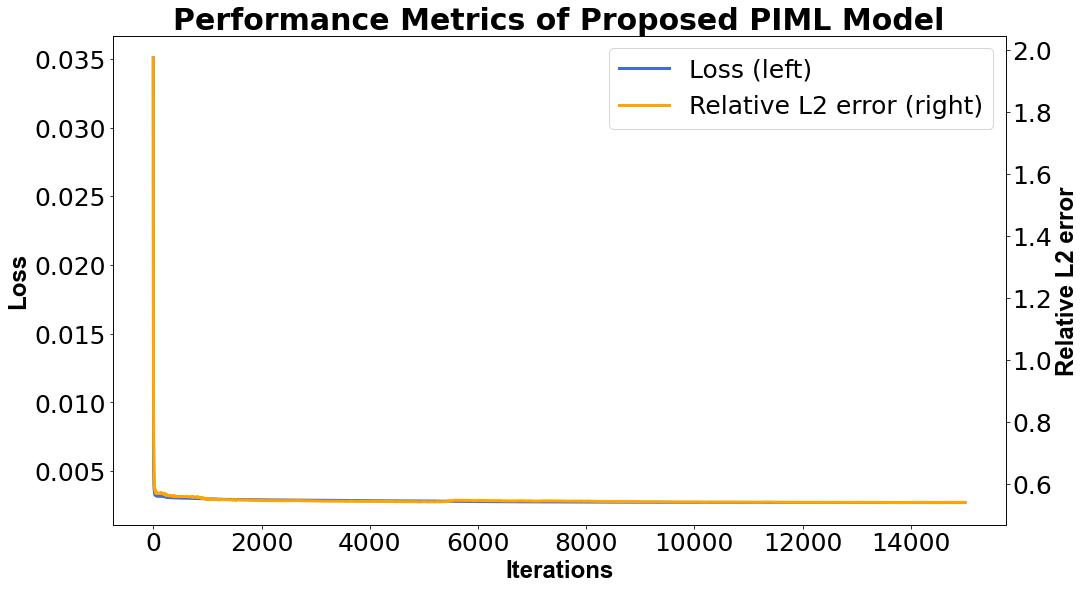

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.020967389035625863
MSE =  0.0029796151864532536
RMSE =  0.05458585152265424
L2 relative error = 0.5178806730538461
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

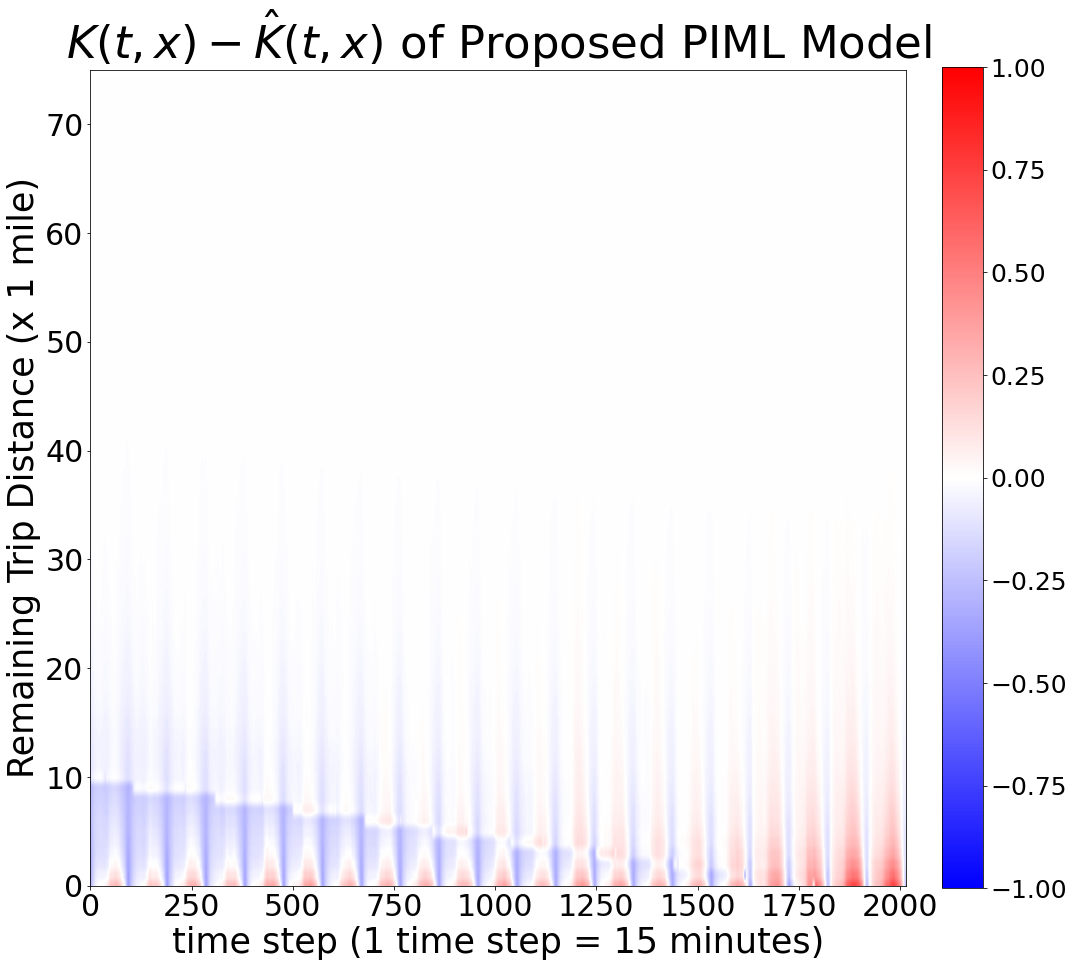

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

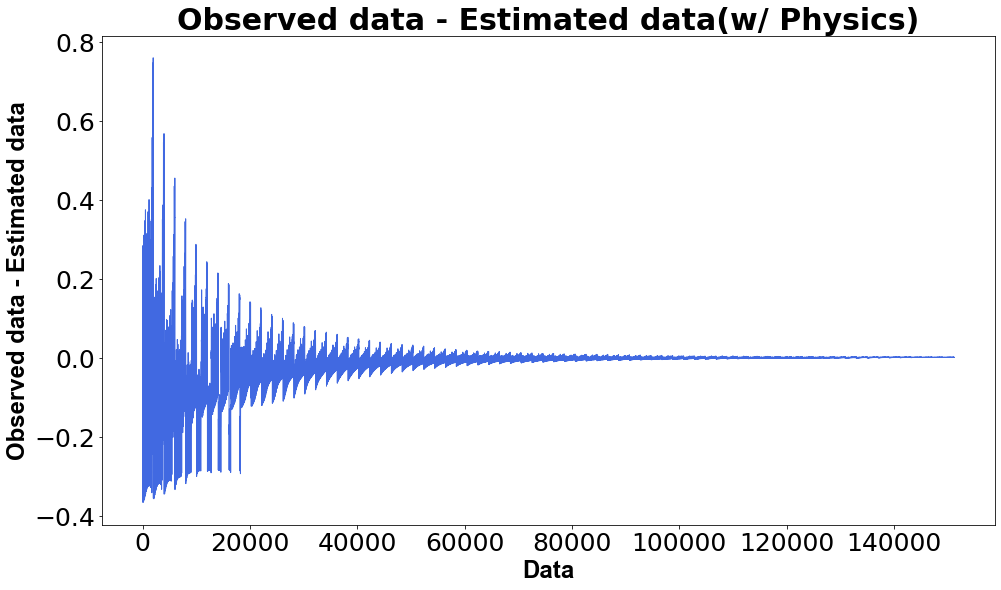

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

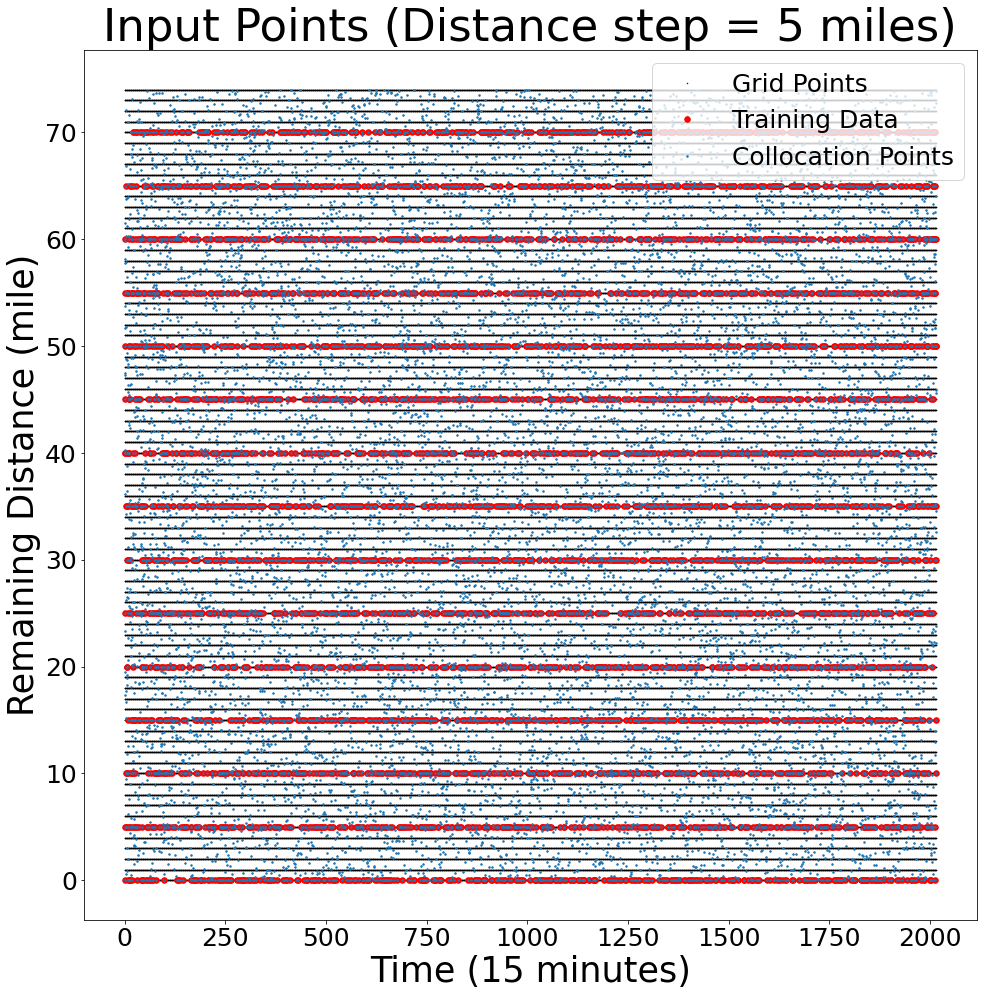

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

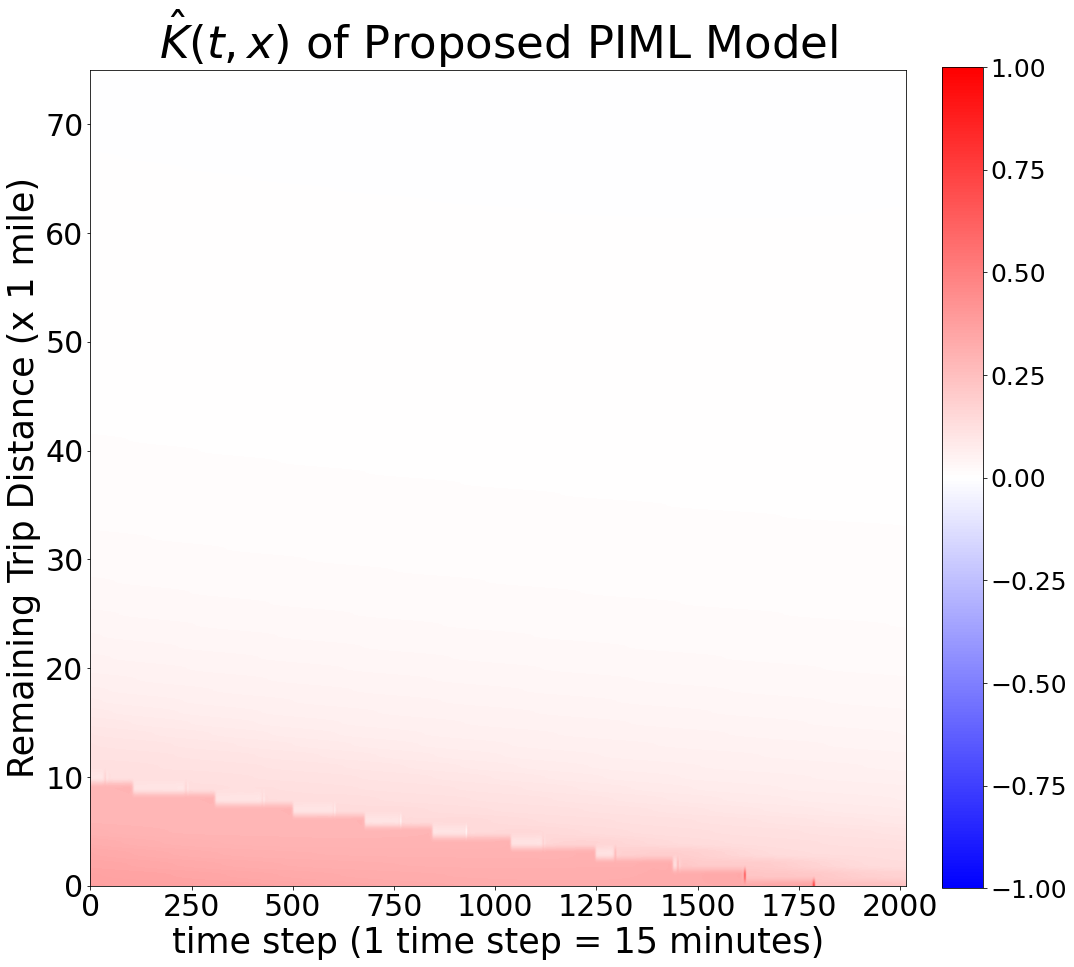

In [22]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)